<a href="https://colab.research.google.com/github/FredPedrosa/youtube_circumplex/blob/main/youtube_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-api-python-client
!pip install openpyxl

import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from transformers import pipeline
from googleapiclient.discovery import build
from google.colab import userdata
import nltk
from nltk.corpus import stopwords
# Configura o Pandas para mostrar barras de progresso
tqdm.pandas()


In [ ]:
# Carregar a chave da API do YouTube
YOUTUBE_API_KEY = userdata.get('YOUTUBE_API_KEY')
VIDEO_ID = 'Vz4Sb1bl1IE' # ID do vídeo (pode ser encontrado na URL do YouTube)

# Construir o serviço da API
youtube = build('youtube', 'v3', developerKey=YOUTUBE_API_KEY)

# Função para coletar comentários
def coletar_comentarios(video_id, limit=100):
    comments = []
    try:
        # Fazer a requisição inicial
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            textFormat='plainText',
            maxResults=100 # Máximo por página
        ).execute()

        while response and len(comments) < limit:
            for item in response['items']:
                comment = item['snippet']['topLevelComment']['snippet']
                comments.append({
                    'author': comment['authorDisplayName'],
                    'published_at': comment['publishedAt'],
                    'text': comment['textDisplay'],
                    'like_count': comment['likeCount']
                })

            # Verificar se há uma próxima página e se ainda não atingimos o limite
            if 'nextPageToken' in response and len(comments) < limit:
                response = youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    textFormat='plainText',
                    pageToken=response['nextPageToken'],
                    maxResults=100
                ).execute()
            else:
                break

        return pd.DataFrame(comments)

    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return pd.DataFrame() # Retorna um DataFrame vazio em caso de erro

In [ ]:
import pandas as pd

# ---------------------------------------------------------------------------------
# PARTE 1: DEFINIR OS VÍDEOS E PARÂMETROS DE COLETA
# ---------------------------------------------------------------------------------


# Dicionário com listas de IDs de vídeo para cada fator
videos_por_fator = {
    'Movimento': [
        'CRCQ6Btlllc', # MC Tuto - Barbie (DJ Glenner)
        'H1DEczvTjgE' # João Gomes - Meu pedaço de pecado
    ],
    'Tradição': [
        'U6reD8UVa0E', # Brenno & Matheus - Descer Pra BC
        '10XarNSkw0s', # Diego e Victor Hugo - Tubarões
    ],
    'Reflexo': [
        '9Sk7RQtSl5g', # ANAVITÓRIA, Vitor Kley - Pupila
        'W62-ZG9tPpI'  # TIAGO IORC - Amei Te Ver
    ],
    'Orgânico': [
        'Kt1MpsQ-jiA', # Cidade Negra - Girassol
        'i1Nm-MJ313w', # Natiruts - Quero Ser Feliz Também
        'K2frSvI81Vk', # Tribo de Jah - Morena Raiz
        'kCE2d33yMNA'  # Maskavo - Um anjo do céu
    ],
    'Intenso': [
        'T1DJ2RdASWA', # Matanza - Bom é Quando Faz Mal
        'TQ7V5tbX-DM', # Raimundos - Quero ver o Oco
        'nkmuqq4TBQ8', # Shaman - Carry On
        'nYc09Xqy3hE'  # Massacration - Evil papagali
    ]
}

# Definir o limite de comentários a serem coletados por VÍDEO
# A cota da API do YouTube é diária e alta, então 5000 é viável, mas pode demorar um pouco.
limite_por_video = 5000

# ---------------------------------------------------------------------------------
# PARTE 2: EXECUÇÃO DA COLETA
# ---------------------------------------------------------------------------------

# Lista para armazenar os DataFrames finais de cada fator
lista_de_dfs_geral = []

print("--- Iniciando coleta robusta de comentários do YouTube ---")

# Loop principal: itera sobre cada fator (ex: 'Movimento')
for fator, lista_de_videos in videos_por_fator.items():
    print(f"\n----- Coletando para o Fator: {fator} -----")

    # Lista para armazenar os comentários deste fator específico
    comentarios_deste_fator = []

    # Loop secundário: itera sobre cada vídeo DENTRO da lista do fator
    for video_id in lista_de_videos:
        print(f"  -> Coletando do vídeo ID: {video_id} (limite: {limite_por_video})")

        # Chama sua função de coleta para este vídeo
        df_video_atual = coletar_comentarios(video_id, limit=limite_por_video)

        # Adiciona os comentários coletados à lista do fator
        if not df_video_atual.empty:
            comentarios_deste_fator.append(df_video_atual)
            print(f"     ...Coletados {len(df_video_atual)} comentários.")
        else:
            print(f"     ...Nenhum comentário coletado ou ocorreu um erro para o vídeo {video_id}.")

    # Verificar se coletamos algum comentário para este fator
    if comentarios_deste_fator:
        # Juntar todos os DataFrames de comentários deste fator em um só
        df_fator_completo = pd.concat(comentarios_deste_fator, ignore_index=True)

        # Adicionar a coluna de identificação do fator
        df_fator_completo['fator_ritmo'] = fator

        # Adicionar o DataFrame deste fator à nossa lista geral
        lista_de_dfs_geral.append(df_fator_completo)
        print(f"----- Total para o fator '{fator}': {len(df_fator_completo)} comentários -----")

# ---------------------------------------------------------------------------------
# PARTE 3: FINALIZAÇÃO E SALVAMENTO
# ---------------------------------------------------------------------------------
if lista_de_dfs_geral:
    # Juntar todos os DataFrames de todos os fatores em um único DataFrame final
    df_final_youtube_robusto = pd.concat(lista_de_dfs_geral, ignore_index=True)

    # Salvar o dataset completo em um arquivo CSV
    df_final_youtube_robusto.to_csv('comentarios_youtube_robusto.csv', index=False)

    print("\n\n--- COLETA FINALIZADA ---")
    print(f"Total de comentários coletados: {len(df_final_youtube_robusto)}")
    print("\nDistribuição final de comentários por fator:")
    display(df_final_youtube_robusto['fator_ritmo'].value_counts())
else:
    print("\n\n--- COLETA FINALIZADA ---")
    print("Nenhum comentário foi coletado. Verifique os IDs dos vídeos e a conexão com a API.")

--- Iniciando coleta robusta de comentários do YouTube ---

----- Coletando para o Fator: Movimento -----
  -> Coletando do vídeo ID: CRCQ6Btlllc (limite: 5000)
     ...Coletados 5000 comentários.
  -> Coletando do vídeo ID: H1DEczvTjgE (limite: 5000)
     ...Coletados 5000 comentários.
----- Total para o fator 'Movimento': 10000 comentários -----

----- Coletando para o Fator: Tradição -----
  -> Coletando do vídeo ID: U6reD8UVa0E (limite: 5000)
     ...Coletados 5000 comentários.
  -> Coletando do vídeo ID: 10XarNSkw0s (limite: 5000)
     ...Coletados 5000 comentários.
----- Total para o fator 'Tradição': 10000 comentários -----

----- Coletando para o Fator: Reflexo -----
  -> Coletando do vídeo ID: 9Sk7RQtSl5g (limite: 5000)
     ...Coletados 5000 comentários.
  -> Coletando do vídeo ID: W62-ZG9tPpI (limite: 5000)
     ...Coletados 5000 comentários.
----- Total para o fator 'Reflexo': 10000 comentários -----

----- Coletando para o Fator: Orgânico -----
  -> Coletando do vídeo ID: 

,count
fator_ritmo,
Intenso,12567
Orgânico,12102
Movimento,10000
Reflexo,10000
Tradição,10000


In [ ]:
# @title Balancear data set

import pandas as pd

# --------------------------------------------------------------------------
# PASSO 1: CARREGAR O DATASET COLETADO
# --------------------------------------------------------------------------
# Carregue o CSV que você gerou na coleta robusta
caminho_csv_robusto = 'comentarios_youtube_robusto.csv'
df_completo = pd.read_csv(caminho_csv_robusto)

print("--- Dataset Original ---")
print(f"Total de comentários: {len(df_completo)}")
print("Distribuição por fator:")
print(df_completo['fator_ritmo'].value_counts())


# --------------------------------------------------------------------------
# PASSO 2: PADRONIZAR O TAMANHO DA AMOSTRA (AMOSTRAGEM)
# --------------------------------------------------------------------------
# Definir o tamanho desejado para cada amostra de fator
tamanho_amostra = 10000

lista_dfs_balanceados = []
fatores_unicos = df_completo['fator_ritmo'].unique()

print(f"\n--- Padronizando para {tamanho_amostra} comentários por fator ---")

for fator in fatores_unicos:
    # Filtrar o DataFrame para o fator atual
    df_fator_atual = df_completo[df_completo['fator_ritmo'] == fator]

    # Verificar se o número de comentários é maior que o tamanho desejado
    if len(df_fator_atual) > tamanho_amostra:
        print(f"Fator '{fator}' tem {len(df_fator_atual)} comentários. Reduzindo para {tamanho_amostra} através de amostragem aleatória.")
        # .sample() pega uma amostra aleatória do DataFrame
        # n=tamanho_amostra -> define o tamanho da amostra
        # random_state=42 -> garante que a amostragem seja sempre a mesma se você rodar o código de novo (reprodutibilidade)
        df_amostra_fator = df_fator_atual.sample(n=tamanho_amostra, random_state=42)
        lista_dfs_balanceados.append(df_amostra_fator)
    else:
        # Se o fator já tem 10.000 ou menos, usamos todos os seus comentários
        print(f"Fator '{fator}' tem {len(df_fator_atual)} comentários. Mantendo todos.")
        lista_dfs_balanceados.append(df_fator_atual)

# Juntar os DataFrames balanceados em um único DataFrame final
df_balanceado = pd.concat(lista_dfs_balanceados, ignore_index=True)


# --------------------------------------------------------------------------
# PASSO 3: VERIFICAR O RESULTADO FINAL
# --------------------------------------------------------------------------
print("\n--- Dataset Balanceado Final ---")
print(f"Total de comentários após balanceamento: {len(df_balanceado)}")
print("Nova distribuição por fator:")
print(df_balanceado['fator_ritmo'].value_counts())

# A partir daqui, você usará o 'df_balanceado' para todas as análises subsequentes
# (limpeza, contagem, visualização, etc.)

--- Dataset Original ---
Total de comentários: 54669
Distribuição por fator:
fator_ritmo
Intenso      12567
Orgânico     12102
Movimento    10000
Reflexo      10000
Tradição     10000
Name: count, dtype: int64

--- Padronizando para 10000 comentários por fator ---
Fator 'Movimento' tem 10000 comentários. Mantendo todos.
Fator 'Tradição' tem 10000 comentários. Mantendo todos.
Fator 'Reflexo' tem 10000 comentários. Mantendo todos.
Fator 'Orgânico' tem 12102 comentários. Reduzindo para 10000 através de amostragem aleatória.
Fator 'Intenso' tem 12567 comentários. Reduzindo para 10000 através de amostragem aleatória.

--- Dataset Balanceado Final ---
Total de comentários após balanceamento: 50000
Nova distribuição por fator:
fator_ritmo
Movimento    10000
Tradição     10000
Reflexo      10000
Orgânico     10000
Intenso      10000
Name: count, dtype: int64


In [ ]:
# @title *(Salvar e importar o data set balanceado)*

# Nome do arquivo que vamos criar
#arquivo_balanceado = 'comentarios_youtube_balanceado.csv'

# Salvar o DataFrame em um arquivo CSV no ambiente do Colab
#print(f"\nSalvando o DataFrame balanceado em '{arquivo_balanceado}'...")
#df_balanceado.to_csv(arquivo_balanceado, index=False)
#print("Arquivo salvo com sucesso!")

import pandas as pd

# Nome do arquivo que você acabou de fazer o upload
nome_arquivo_para_carregar = 'comentarios_youtube_balanceado.csv'

# Carregar o arquivo CSV para um DataFrame
try:
    # Vamos chamar a nova variável de 'df' para simplificar
    df = pd.read_csv(nome_arquivo_para_carregar)

    print("Dataset balanceado carregado com sucesso!")
    print(f"Total de linhas: {len(df)}")
    print("\nDistribuição por fator:")
    print(df['fator_ritmo'].value_counts())

    print("\nAmostra dos dados:")
    display(df.head())

except FileNotFoundError:
    print(f"ERRO: Arquivo '{nome_arquivo_para_carregar}' não encontrado.")
    print("Por favor, faça o upload do arquivo para o Colab antes de continuar.")

ERRO: Arquivo 'comentarios_youtube_balanceado.csv' não encontrado.
Por favor, faça o upload do arquivo para o Colab antes de continuar.


In [ ]:
# --------------------------------------------------------------------------
# PASSO 1: CARREGAR O NOVO DATASET BALANCEADO
# --------------------------------------------------------------------------

df_robusto = df

# --------------------------------------------------------------------------
# PASSO 2: DEFINIR A FUNÇÃO DE LIMPEZA (A MESMA DE ANTES)
# --------------------------------------------------------------------------
def limpar_texto(texto):
    if not isinstance(texto, str):
        return "" # Retorna uma string vazia se o texto não for uma string
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    texto = re.sub(r'\@\w+|\#\w+', '', texto)
    texto = texto.lower()
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    texto = re.sub(r'\d+', '', texto)
    texto = " ".join(texto.split())
    return texto

# --------------------------------------------------------------------------
# PASSO 3: CRIAR A LISTA DE STOPWORDS ABRANGENTE E ATUALIZADA
# --------------------------------------------------------------------------
print("\nPreparando a lista de stopwords atualizada...")
try:
    portuguese_stops = set(stopwords.words('portuguese'))
except LookupError:
    nltk.download('stopwords')
    portuguese_stops = set(stopwords.words('portuguese'))

# Palavras genéricas para ignorar
palavras_extras_gerais = {
    'música', 'som', 'letra', 'clipe', 'video', 'gente', 'tá', 'né', 'faz', 'ver', 'sempre',
    'ainda', 'tudo', 'coisa', 'dia', 'dms', 'aqui', 'pra', 'vou', 'vai', 'ser', 'ter',
    'quer', 'mim', 'bem', 'agora', 'tão', 'só', 'jao', 'pro', 'vc', 'mt', 'td'
}

# Palavras específicas do contexto dos NOVOS vídeos
stopwords_contexto_novo = {
    # Movimento
    'tuto', 'glenner', 'barbie', 'nilo', 'paiva', 'marques', 'fuimlk', 'mlk',
    'ahn', 'joão', 'gomes', 'duas', 'cara', 'achava', 'senta', 'nóis',
    'manhã', 'dessa', 'querendo', 'putinhas', 'sabe', 'nesse', 'dar',
    'ouvir', 'toma', 'moleque', 'canta', 'lindinhas', 'joga', 'fim', 'valentino',
    'sexta', 'pique', 'outra', 'sentar','puxa', 'semana', 'drake','champanhe',
    'bigode', 'quarto',
    # Tradição
    'brenno', 'matheus', 'descer', 'bc', 'simone', 'mendes', 'saudade', 'proibida',
    'musica', 'tubarões', 'deixou', 'devo', 'deve', 'explicações',
    'demais', 'sucesso', 'mar', 'ano', 'vcs', 'saber', 'nessa', 'dessa', 'nao',
    'pergunte', 'direito', 'vida','ficou', 'todo', 'perguntar', 'parte','rolou',
    '❤❤❤', 'hugo', 'diego', 'victor','vezes','dupla','vim',
    # Reflexo
    'anavitoria', 'anavitória', 'vitor', 'kley', 'pupila', 'lagum', 'iza',
    'bom', 'parabéns', 'alguém', 'dizer', 'quase', 'boa', 'bruna', 'anos',
    'dilatar', 'demais', 'tempo', 'tiago', 'fez', 'dessa', 'sei', 'ninguém', 'melhor',
    'cheiro', 'quanto', 'tropeça', 'sai', 'escutando', 'lindo', 'vídeo',
    'tanto', 'vez', 'cor', 'tatata', 'clip', 'pessoa', 'cabelo', 'marquezine',
    'passa',  'rima', 'porque', 'quarentena',
    # Orgânico
    'cidade', 'negra', 'girassol', 'natiruts', 'alguém', 'ouvindo', 'quero',
    'brasil', 'vem', 'todos', 'reggae', 'banda', 'músicas', 'dessa', 'hoje',
    'anjo', 'toda', 'canção',
    # Intenso
    'torture', 'squad', 'fallen', 'ones', 'matanza', 'mal', 'raimundos', 'oco',
    'shaman', 'carry', 'rock', 'banda', 'the', 'metal', 'cara', 'loro',
    'biscoito', 'quero', 'massacration', 'alguém', 'rodolfo', 'rip', 'matos',
    'andré', 'porra', 'lôro', 'andre', 'nao', 'caralho', 'nunca', 'your', 'puta',
    'canisso', 'kkkk', 'dessa', 'bandas', 'caras', 'angra', 'and', 'you', 'kkk',
    'heavy', 'ouvir', 'kkkkk', 'saudades', 'from', 'mundo',  'mano', 'melhores',
    'fazer', 'guitarra','vendo', 'pai', 'power', 'assim', 'acho','evil','dentro',
    'papagali'
}

# Juntar todas as stopwords em uma única lista
portuguese_stops.update(palavras_extras_gerais)
portuguese_stops.update(stopwords_contexto_novo)
print("Lista de stopwords atualizada e pronta.")


# --------------------------------------------------------------------------
# PASSO 4: APLICAR A LIMPEZA NO NOVO DATAFRAME
# --------------------------------------------------------------------------
print("\nAplicando a limpeza nos comentários...")
df_robusto['texto_limpo'] = df_robusto['text'].apply(limpar_texto)
print("Coluna 'texto_limpo' criada.")


# --------------------------------------------------------------------------
# PASSO 5: RODAR A ANÁLISE DE FREQUÊNCIA POR FATOR (SEU CÓDIGO)
# --------------------------------------------------------------------------
# Agora, o seu código de análise de frequência vai funcionar perfeitamente
# com o novo DataFrame 'df_robusto' e a lista de stopwords atualizada.

# O nome do DataFrame agora é 'df_robusto'
fatores_unicos = df_robusto['fator_ritmo'].unique()
resultados_por_fator = {}

print("\n--- Iniciando análise de frequência de palavras para cada fator RITMO (Amostra Robusta) ---")
for fator in fatores_unicos:
    print(f"\n----- Analisando Fator: {fator} -----")
    df_subset = df_robusto[df_robusto['fator_ritmo'] == fator]
    textao_fator = " ".join(df_subset['texto_limpo'].dropna()) # .dropna() para segurança
    lista_de_palavras_fator = [
        palavra for palavra in textao_fator.split()
        if palavra not in portuguese_stops and len(palavra) > 2
    ]
    contagem_palavras_fator = Counter(lista_de_palavras_fator)
    resultados_por_fator[fator] = contagem_palavras_fator

    numero_de_palavras_para_mostrar = 20 # Aumentei para 20
    print(f"As {numero_de_palavras_para_mostrar} palavras mais comuns para '{fator}':")
    print(contagem_palavras_fator.most_common(numero_de_palavras_para_mostrar))


Preparando a lista de stopwords atualizada...
Lista de stopwords atualizada e pronta.

Aplicando a limpeza nos comentários...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Coluna 'texto_limpo' criada.

--- Iniciando análise de frequência de palavras para cada fator RITMO (Amostra Robusta) ---

----- Analisando Fator: Movimento -----
As 20 palavras mais comuns para 'Movimento':
[('amo', 442), ('voz', 368), ('gata', 318), ('linda', 281), ('top', 266), ('deus', 251), ('show', 230), ('gosto', 147), ('vaqueiro', 146), ('charmosa', 142), ('amiga', 138), ('louco', 136), ('dançando', 133), ('novo', 131), ('rico', 131), ('maravilha', 130), ('chique', 130), ('maloqueiro', 128), ('limpa', 121), ('cansou', 121)]

----- Analisando Fator: Tradição -----
As 20 palavras mais comuns para 'Tradição':
[('top', 306), ('amor', 279), ('amo', 219), ('linda', 210), ('ruim', 190), ('amei', 145), ('inferno', 119), ('deus', 116), ('comigo', 113), ('perfeita', 110), ('viciada', 100), ('voz', 95), ('moda', 94), ('recordações', 94), ('gostei', 90), ('pedrada', 90), ('nada', 86), ('show', 83), ('pancada', 81), ('lixo', 77)]

----- Analisando Fator: Reflexo -----
As 20 palavras mais co

In [ ]:
# @title Carregar e preparar o ANEW-BR

caminho = '/content/ANEW_BR.xlsx'
df_lexico = pd.read_excel(caminho)

print("Arquivo Excel carregado.")
print(f"Número inicial de linhas: {len(df_lexico)}")

# --- AJUSTE DOS NOMES DAS COLUNAS ---
coluna_palavra = 'Word'
coluna_valencia = 'Val_mean'
coluna_ativacao = 'Aro_mean'

# --------------------------------------------------------------------------
# --- Passo 1: Limpeza e Padronização ---
# --------------------------------------------------------------------------


# Colocar a coluna de palavras em minúsculas
df_lexico[coluna_palavra] = df_lexico[coluna_palavra].str.lower()

# --------------------------------------------------------------------------
# --- Passo 2: Identificar e Remover TODAS as Ocorrências de Duplicatas (Sua Escolha) ---
# --------------------------------------------------------------------------

# Verificar o número de linhas antes da remoção
num_linhas_antes = len(df_lexico)

# O método .drop_duplicates() com keep=False remove TODAS as linhas que são duplicadas.
# Isso significa que se uma palavra aparece 2 ou mais vezes, todas as suas entradas serão removidas.
print("\nRemovendo todas as ocorrências de palavras duplicadas...")
df_lexico.drop_duplicates(subset=[coluna_palavra], keep=False, inplace=True)

# Verificar o número de linhas após a remoção
num_linhas_depois = len(df_lexico)
print(f"Número de linhas após a remoção completa das duplicatas: {num_linhas_depois}")
print(f"Total de {num_linhas_antes - num_linhas_depois} linhas associadas a duplicatas foram removidas.")

# --------------------------------------------------------------------------
# --- Passo 3: Criar o Dicionário (Com um léxico mais enxuto e sem ambiguidades) ---
# --------------------------------------------------------------------------

# Definir a palavra como o índice do DataFrame (agora garantidamente único)
df_lexico.set_index(coluna_palavra, inplace=True)

# Criar o dicionário no formato {palavra: (valencia, ativacao)}
lexico_anew_br = {
    palavra: (valores[coluna_valencia], valores[coluna_ativacao])
    for palavra, valores in df_lexico.to_dict('index').items()
}

print("\nDicionário do léxico criado com sucesso!")

# Exibir um exemplo para confirmar
print("Exemplo do dicionário: 'amor' ->", lexico_anew_br.get('amor'))
print("Exemplo do dicionário: 'triste' ->", lexico_anew_br.get('triste'))

Arquivo Excel carregado.
Número inicial de linhas: 1046

Removendo todas as ocorrências de palavras duplicadas...
Número de linhas após a remoção completa das duplicatas: 1044
Total de 2 linhas associadas a duplicatas foram removidas.

Dicionário do léxico criado com sucesso!
Exemplo do dicionário: 'amor' -> (8.75, 4.39)
Exemplo do dicionário: 'triste' -> (1.73, 5.28)


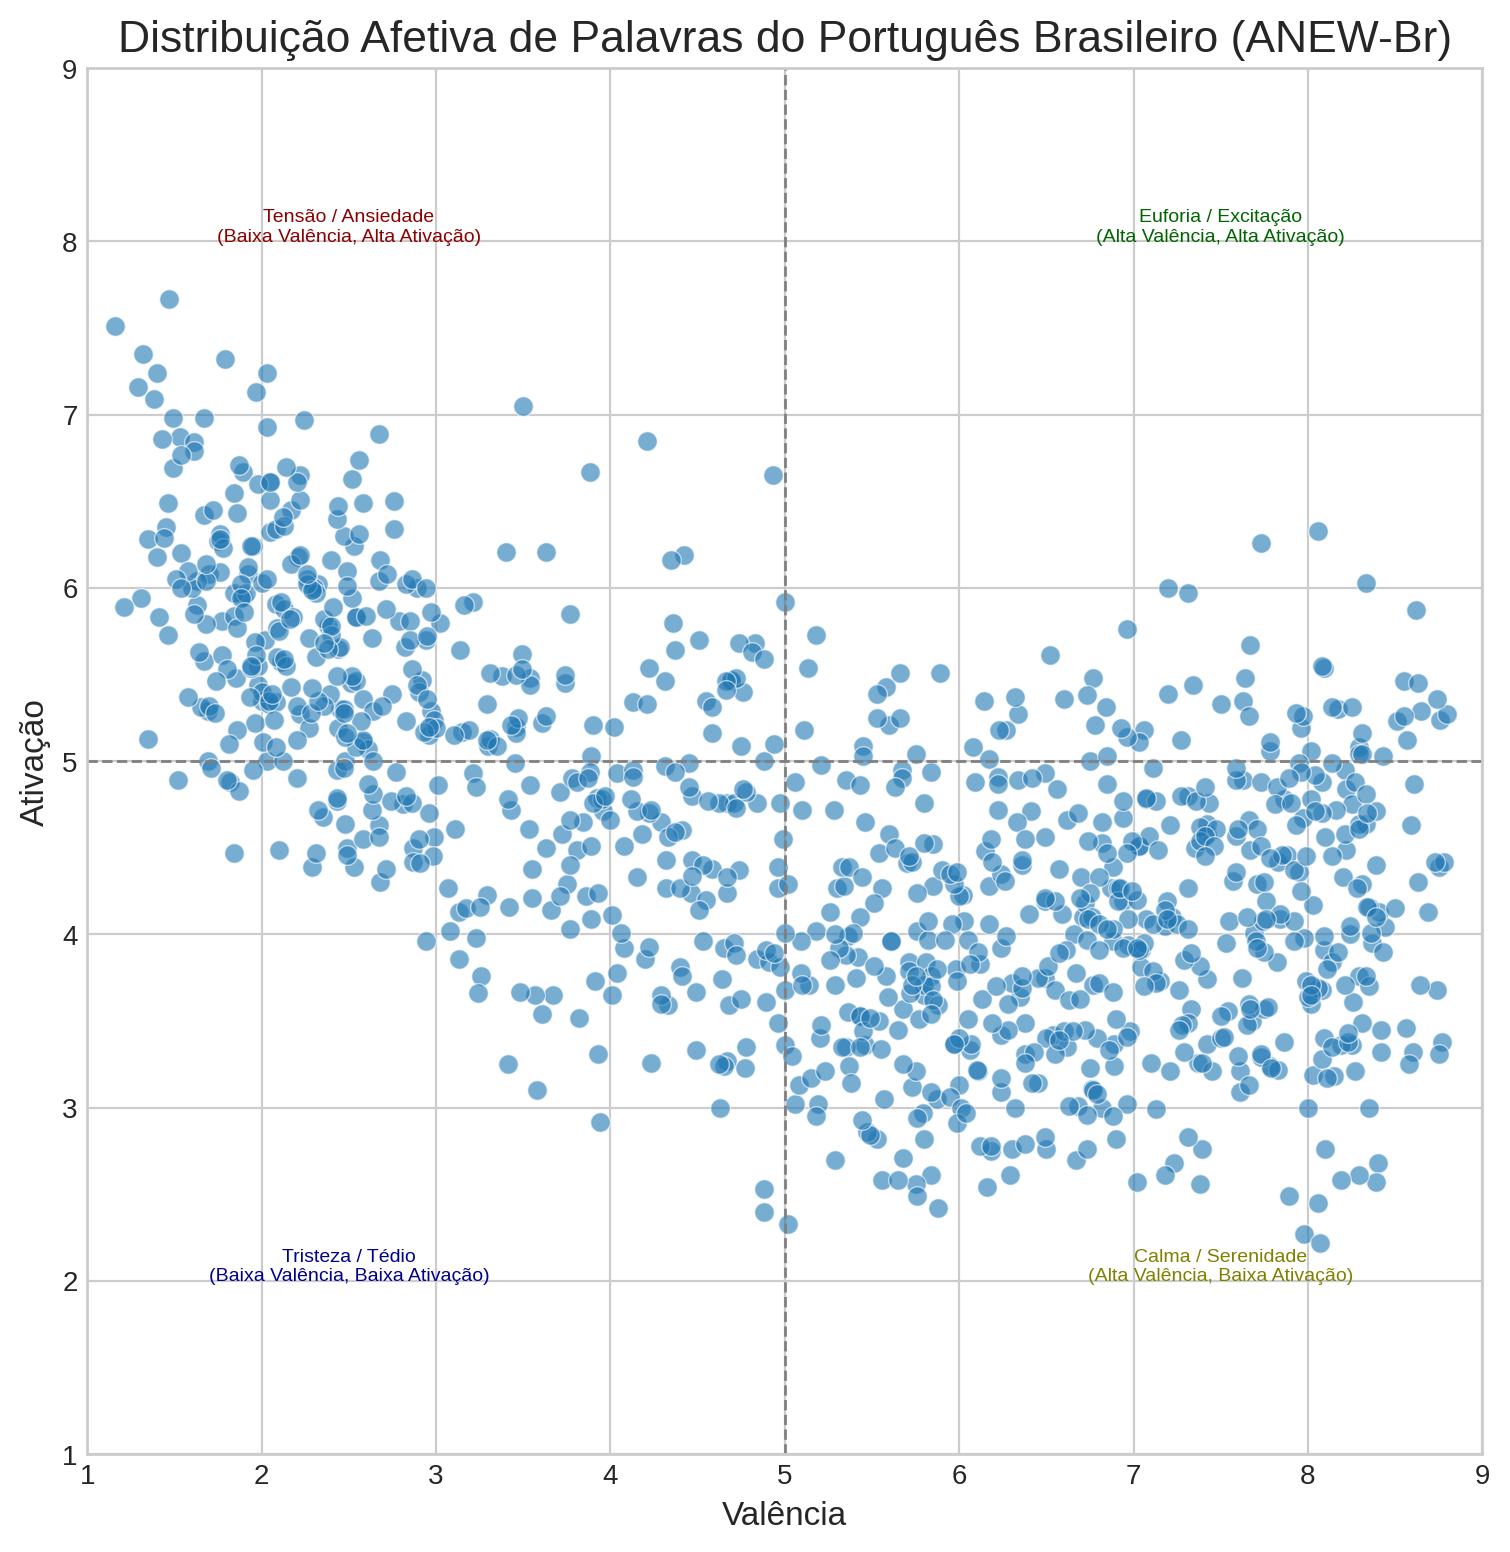

In [ ]:
# @title Visualização da distribuição em 2D do ANEW-BR
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns

 #1. Configurar o estilo e o tamanho da figura
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(9, 9)) # Deixei quadrado para o aspecto ficar melhor

# 2. Criar o gráfico de dispersão (scatter plot) com os eixos trocados
sns.scatterplot(
    data=df_lexico,
    x=coluna_valencia,
    y=coluna_ativacao,
    alpha=0.6,
    s=50,
    edgecolor='w',
    linewidth=0.5
)

# 3. Adicionar linhas de referência para os quadrantes
# A linha vertical (x=5) agora corta o eixo de Valência.
# A linha horizontal (y=5) agora corta o eixo de Ativação.
plt.axvline(x=5, color='gray', linestyle='--', linewidth=1)
plt.axhline(y=5, color='gray', linestyle='--', linewidth=1)

# 4. CORRIGIR as coordenadas das anotações para os quadrantes
# As coordenadas (x, y) agora correspondem a (valência, ativação)
# Quadrante Superior Esquerdo: Baixa Valência, Alta Ativação
plt.text(2.5, 8.0, 'Tensão / Ansiedade\n(Baixa Valência, Alta Ativação)', fontsize=7, ha='center', color='darkred')
# Quadrante Superior Direito: Alta Valência, Alta Ativação
plt.text(7.5, 8.0, 'Euforia / Excitação\n(Alta Valência, Alta Ativação)', fontsize=7, ha='center', color='darkgreen')
# Quadrante Inferior Esquerdo: Baixa Valência, Baixa Ativação
plt.text(2.5, 2.0, 'Tristeza / Tédio\n(Baixa Valência, Baixa Ativação)', fontsize=7, ha='center', color='darkblue')
# Quadrante Inferior Direito: Alta Valência, Baixa Ativação
plt.text(7.5, 2.0, 'Calma / Serenidade\n(Alta Valência, Baixa Ativação)', fontsize=7, ha='center', color='olive')


# 5. CORRIGIR os rótulos (labels) dos eixos
plt.title('Distribuição Afetiva de Palavras do Português Brasileiro (ANEW-Br)', fontsize=16)
plt.xlabel('Valência', fontsize=12) # Eixo X é Valência
plt.ylabel('Ativação', fontsize=12) # Eixo Y é Ativação

# 6. Definir os limites dos eixos para que fiquem bem enquadrados
plt.xlim(1, 9)
plt.ylim(1, 9)

#nome_do_arquivo = 'grafico_anew_alta_resolucao.png'
#plt.savefig(nome_do_arquivo, dpi=2400, bbox_inches='tight')

# 7. Exibir o gráfico
plt.show()

In [ ]:
# Lista para armazenar os resultados da análise quantitativa
perfis_afetivos = []

print("--- Calculando o Perfil Afetivo Médio Ponderado para cada Fator ---")

for fator, contagem_de_palavras in resultados_por_fator.items():

    # Listas para guardar os valores ponderados para este fator
    valencias_ponderadas = []
    ativacoes_ponderadas = []
    pesos_totais = 0

    for palavra, frequencia in contagem_de_palavras.items():
        if palavra in lexico_anew_br:
            valencia, ativacao = lexico_anew_br[palavra]

            # Adicionar o valor multiplicado pela frequência (peso)
            valencias_ponderadas.append(valencia * frequencia)
            ativacoes_ponderadas.append(ativacao * frequencia)
            pesos_totais += frequencia

    # Calcular a média ponderada, se tivermos encontrado alguma palavra no léxico
    if pesos_totais > 0:
        valencia_media_ponderada = sum(valencias_ponderadas) / pesos_totais
        ativacao_media_ponderada = sum(ativacoes_ponderadas) / pesos_totais

        perfis_afetivos.append({
            'Fator_RITMO': fator,
            'Valencia_Media': valencia_media_ponderada,
            'Ativacao_Media': ativacao_media_ponderada,
            'Total_Palavras_Mapeadas': pesos_totais
        })

# Criar um DataFrame com o resumo
df_perfil_afetivo = pd.DataFrame(perfis_afetivos)

print("\n--- Resultado da Análise Quantitativa ---")
display(df_perfil_afetivo.sort_values(by='Ativacao_Media', ascending=False))

--- Calculando o Perfil Afetivo Médio Ponderado para cada Fator ---

--- Resultado da Análise Quantitativa ---


,Fator_RITMO,Valencia_Media,Ativacao_Media,Total_Palavras_Mapeadas
1,Tradição,6.374217,4.574640,2623
0,Movimento,6.784942,4.354904,3422
2,Reflexo,7.234299,4.346802,3724
4,Intenso,6.380653,4.344265,3245
3,Orgânico,7.321909,4.263644,4394


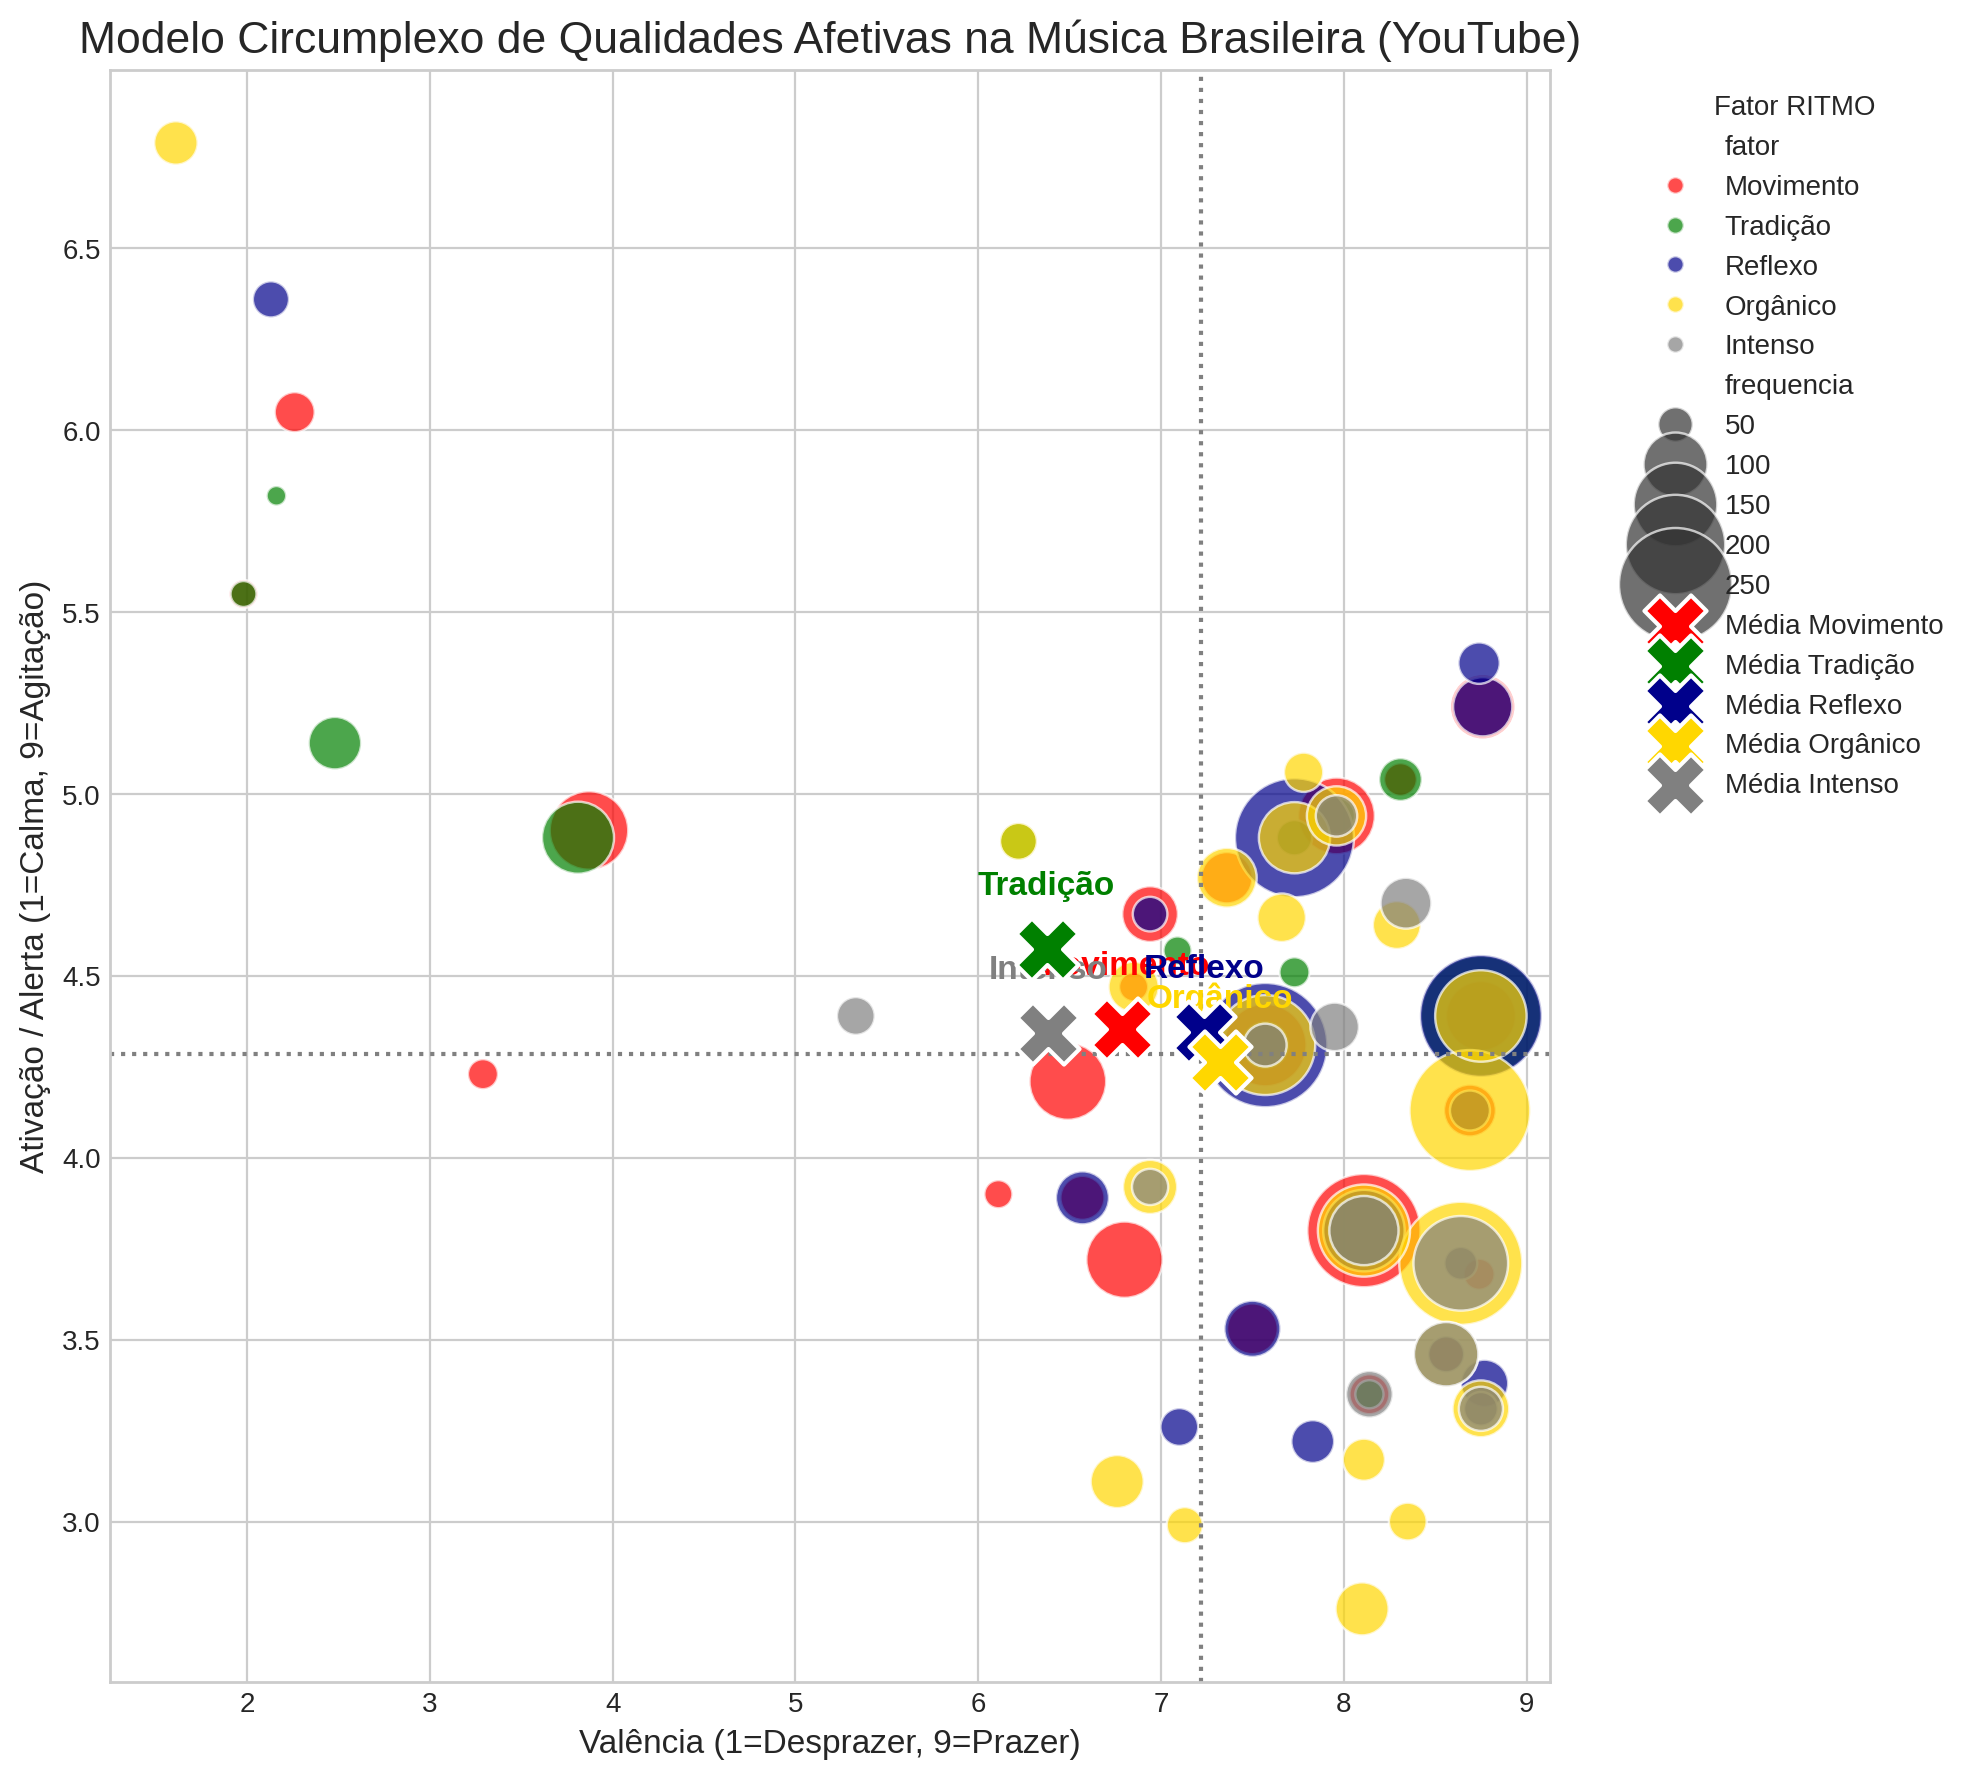

In [ ]:
# --- PARTE A: Preparar os dados para o plot ---

dados_para_plotar = []
# Loop para passar por cada fator (Movimento, Reflexo, etc.)
for fator, contagem_de_palavras in resultados_por_fator.items():
    # Loop para passar pelas palavras mais comuns daquele fator
    for palavra, frequencia in contagem_de_palavras.most_common(100):
        # Verificar se a palavra existe no nosso léxico
        if palavra in lexico_anew_br:
            # Pegar os valores de valência e ativação do léxico
            valencia, ativacao = lexico_anew_br[palavra]
            # Adicionar tudo a nossa lista de dados prontos
            dados_para_plotar.append({
                'fator': fator,
                'palavra': palavra,
                'frequencia': frequencia,
                'valencia': valencia,
                'ativacao': ativacao
            })

# Converter a lista em um DataFrame do Pandas para facilitar a visualização
df_plot_final = pd.DataFrame(dados_para_plotar)


# --- PARTE B: Criar a visualização com cores personalizadas ---

# Verificar se temos dados para plotar
if df_plot_final.empty:
    print("Nenhum dado para plotar. Verifique seu léxico e suas contagens.")
else:
    # 1. Definir a nossa paleta de cores personalizada
    # Usaremos um dicionário: {Nome do Fator: 'cor'}
    cores_personalizadas = {
        'Movimento': 'red',     # Vermelho para um fator energético
        'Reflexo':   'darkblue',  # Azul escuro para um fator mais introspectivo
        'Tradição':  'green',   # Verde, talvez associado a algo mais tradicional/raiz
        'Intenso':   'gray',   # Preto ou cinza escuro para o fator Intenso
        'Orgânico':  'gold'      # Amarelo/dourado para algo mais "orgânico"/acústico
    }

    # 2. Configurar o gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 9))

    # 3. Plotar as nuvens de palavras usando a paleta personalizada
    sns.scatterplot(
        data=df_plot_final,
        x='valencia',
        y='ativacao',
        hue='fator',       # A cor ainda é baseada no fator...
        palette=cores_personalizadas, # ...mas agora usamos nosso dicionário de cores!
        size='frequencia',
        sizes=(50, 2000),
        alpha=0.7,
        ax=ax
    )

    # 4. Plotar os "centros de gravidade"
    # Vamos usar as mesmas cores para os marcadores de média para consistência
    for fator_nome in df_perfil_afetivo['Fator_RITMO'].unique():
        # Filtrar o DataFrame de perfis para o fator atual
        perfil = df_perfil_afetivo[df_perfil_afetivo['Fator_RITMO'] == fator_nome]

        if not perfil.empty:
            ax.scatter(
                x=perfil['Valencia_Media'],
                y=perfil['Ativacao_Media'],
                marker='X',
                s=500,
                color=cores_personalizadas.get(fator_nome, 'gray'), # Pega a cor do dicionário
                edgecolor='white', # Adiciona uma borda branca para destacar
                linewidth=1.5,
                label=f'Média {fator_nome}', # Adiciona à legenda
                zorder=10 # Garante que fique por cima dos outros pontos
            )
            ax.text(
                x=perfil['Valencia_Media'].values[0],
                y=perfil['Ativacao_Media'].values[0] + 0.15,
                s=fator_nome, # Apenas o nome do fator
                color=cores_personalizadas.get(fator_nome, 'gray'),
                ha='center',
                weight='bold',
                fontsize=12
            )

    # 5. Configurações finais do gráfico
    ax.axhline(df_plot_final['ativacao'].mean(), color='gray', linestyle=':')
    ax.axvline(df_plot_final['valencia'].mean(), color='gray', linestyle=':')
    ax.set_xlabel('Valência (1=Desprazer, 9=Prazer)', fontsize=12)
    ax.set_ylabel('Ativação / Alerta (1=Calma, 9=Agitação)', fontsize=12)
    ax.set_title('Modelo Circumplexo de Qualidades Afetivas na Música Brasileira (YouTube)', fontsize=16)

    # Melhorar a legenda
    handles, labels = ax.get_legend_handles_labels()
    # Manter apenas as legendas dos fatores principais na legenda
    # (Isso evita que cada ponto de média crie uma nova entrada na legenda)
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), title='Fator RITMO', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


Calculando os perfis afetivos médios...
DataFrame 'df_perfil_afetivo' criado com sucesso.

Gerando a visualização final...


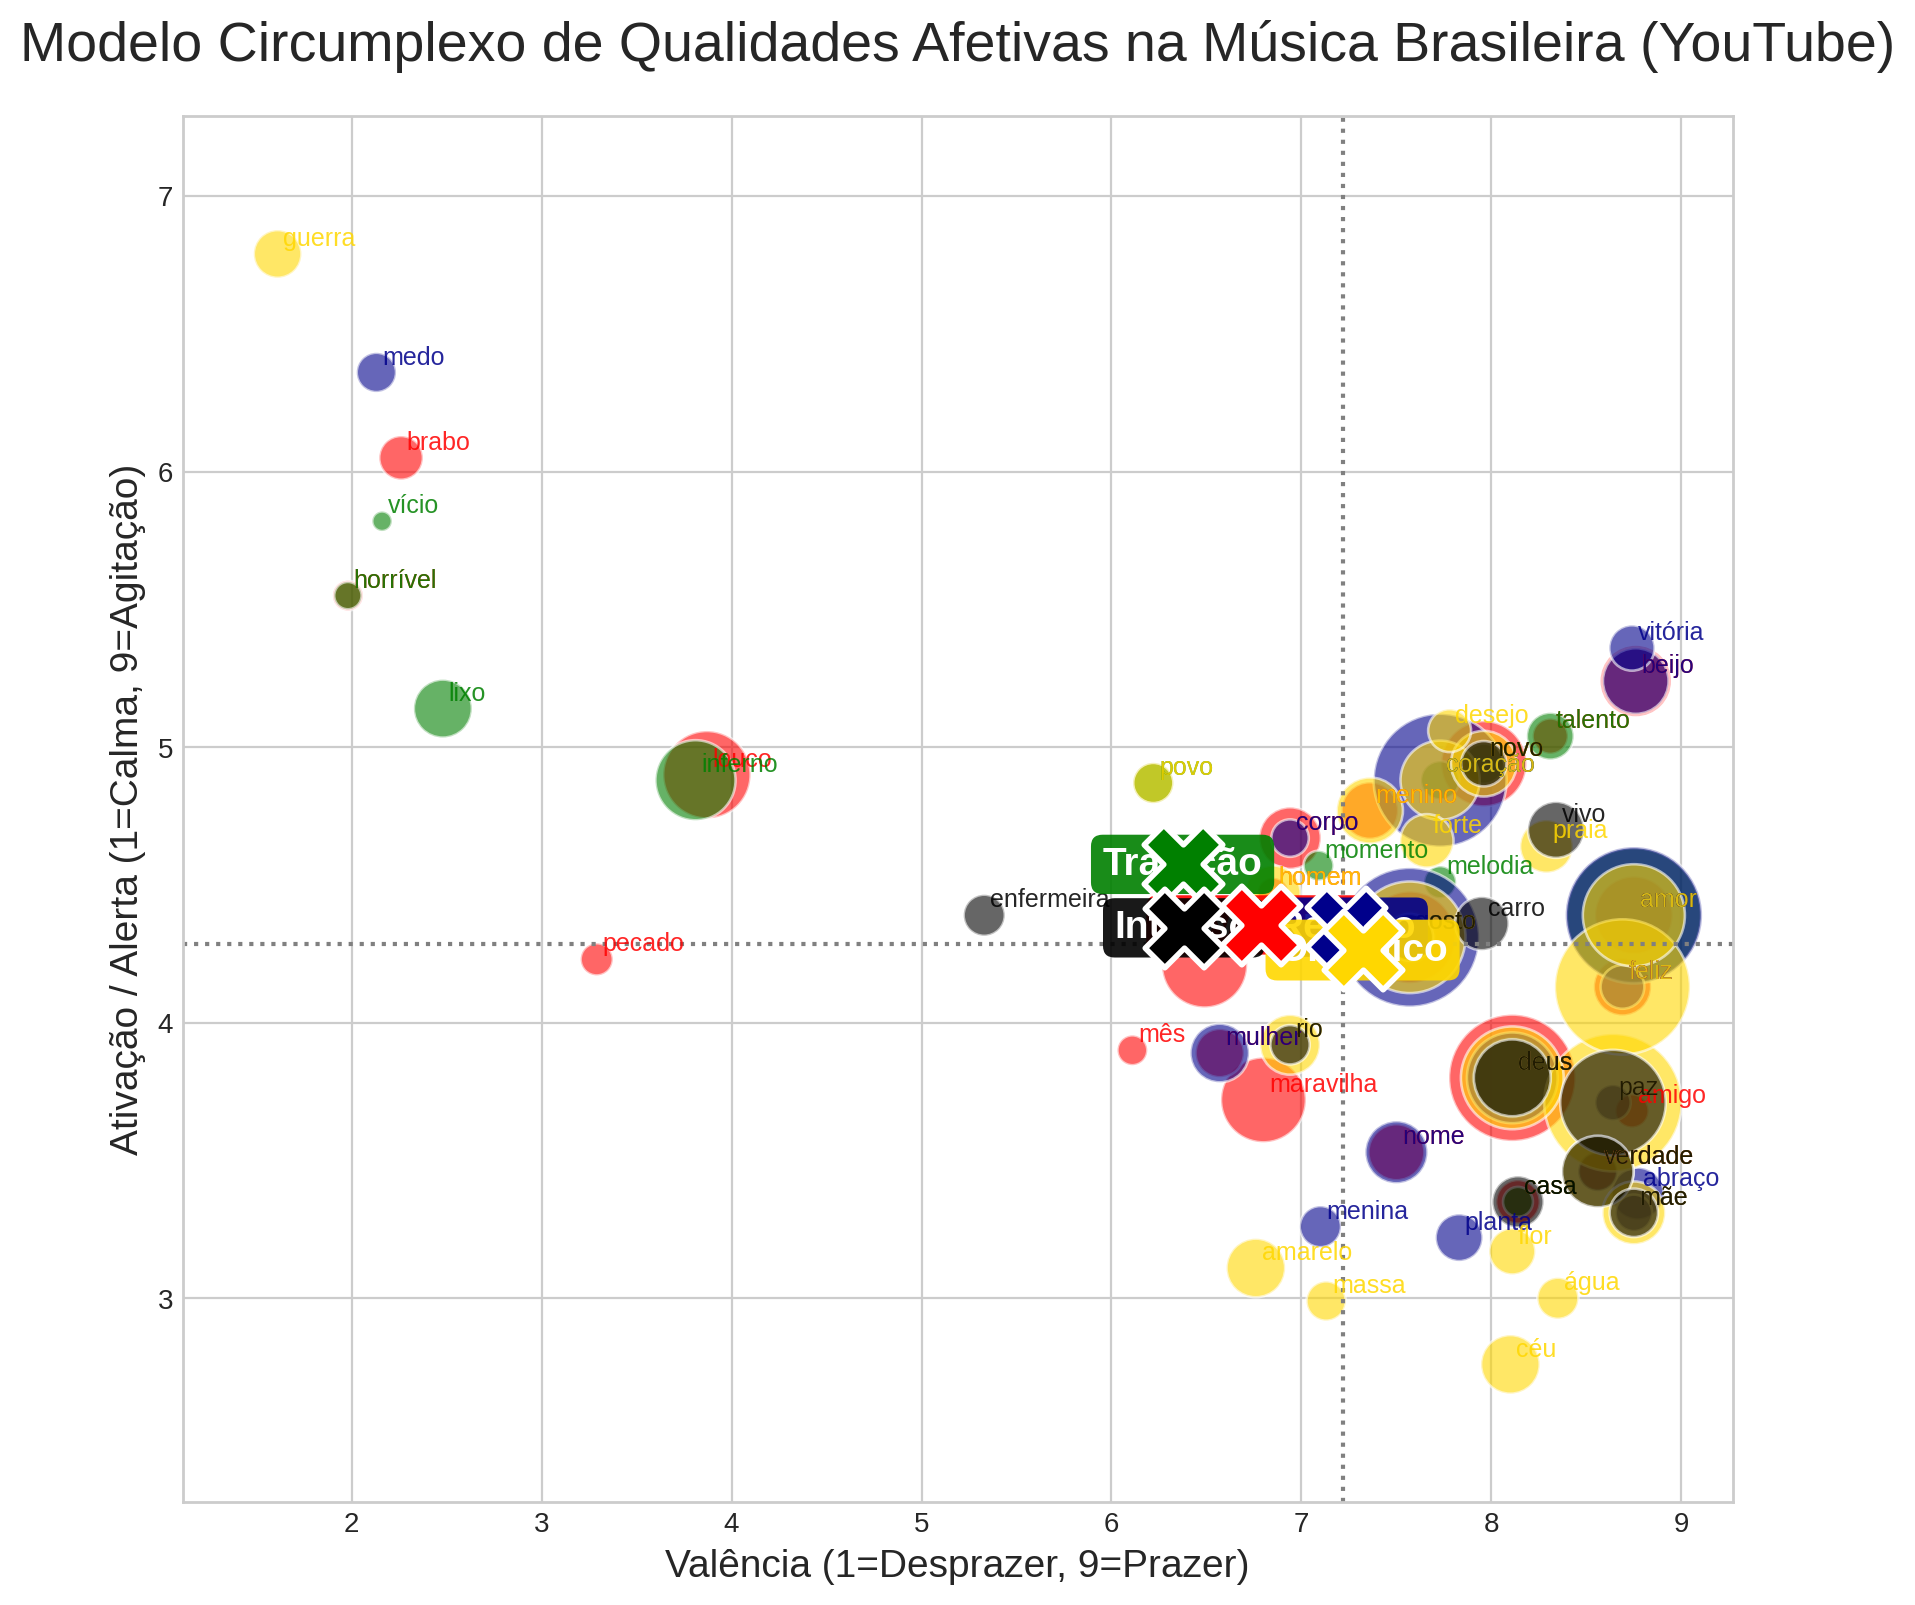

In [ ]:
# --- PARTE 2: CRIAR o DataFrame 'df_perfil_afetivo' ---
# Este bloco calcula as médias ponderadas.

print("\nCalculando os perfis afetivos médios...")
perfis_afetivos = []
for fator, contagem_de_palavras in resultados_por_fator.items():
    valencias_ponderadas = []
    ativacoes_ponderadas = []
    pesos_totais = 0
    for palavra, frequencia in contagem_de_palavras.items():
        if palavra in lexico_anew_br:
            valencia, ativacao = lexico_anew_br[palavra]
            valencias_ponderadas.append(valencia * frequencia)
            ativacoes_ponderadas.append(ativacao * frequencia)
            pesos_totais += frequencia
    if pesos_totais > 0:
        valencia_media_ponderada = sum(valencias_ponderadas) / pesos_totais
        ativacao_media_ponderada = sum(ativacoes_ponderadas) / pesos_totais
        perfis_afetivos.append({
            'Fator_RITMO': fator,
            'Valencia_Media': valencia_media_ponderada,
            'Ativacao_Media': ativacao_media_ponderada
        })
df_perfil_afetivo = pd.DataFrame(perfis_afetivos)
print("DataFrame 'df_perfil_afetivo' criado com sucesso.")


# --- PARTE 3: CRIAR a Visualização (O código que você já tem) ---
# Agora este bloco vai funcionar, pois 'df_plot_final' e 'df_perfil_afetivo' existem.

print("\nGerando a visualização final...")
if df_plot_final.empty:
    print("Nenhum dado para plotar. Verifique seu léxico e suas contagens.")
else:
    # (Cole aqui o código de visualização que eu te passei na última mensagem,
    #  começando pela definição de 'cores_personalizadas' e 'plt.style.use'...)
    # 1. Definir a paleta de cores personalizada
    cores_personalizadas = {
        'Movimento': 'red', 'Reflexo': 'darkblue', 'Tradição': 'green',
        'Intenso': 'black', 'Orgânico': 'gold'
    }

    # 2. Configurar o gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 9))

    # 3. Plotar as nuvens de palavras SEM a legenda automática
    sns.scatterplot(
        data=df_plot_final, x='valencia', y='ativacao', hue='fator',
        palette=cores_personalizadas, size='frequencia', sizes=(50, 2500),
        alpha=0.6, ax=ax, legend=False
    )

    # 4. Adicionar o nome de cada palavra no gráfico
    for index, row in df_plot_final.iterrows():
        ax.text(
            x=row['valencia'] + 0.03, y=row['ativacao'] + 0.03, s=row['palavra'],
            fontdict=dict(color=cores_personalizadas.get(row['fator']), size=9, alpha=0.85)
        )

    # 5. Plotar e rotular os "centros de gravidade"
    for fator_nome in df_perfil_afetivo['Fator_RITMO'].unique():
        perfil = df_perfil_afetivo[df_perfil_afetivo['Fator_RITMO'] == fator_nome]
        if not perfil.empty:
            cor_fator = cores_personalizadas.get(fator_nome, 'gray')
            ax.scatter(
                x=perfil['Valencia_Media'], y=perfil['Ativacao_Media'], marker='X', s=800,
                color=cor_fator, edgecolor='white', linewidth=2, zorder=10
            )
            ax.text(
                x=perfil['Valencia_Media'].values[0], y=perfil['Ativacao_Media'].values[0],
                s=fator_nome, color='white', ha='center', va='center', weight='bold', fontsize=14,
                bbox=dict(boxstyle="round,pad=0.3", fc=cor_fator, ec="none", alpha=0.9)
            )

    # 6. Configurações finais do gráfico
    ax.axhline(df_plot_final['ativacao'].mean(), color='gray', linestyle=':')
    ax.axvline(df_plot_final['valencia'].mean(), color='gray', linestyle=':')
    ax.set_xlabel('Valência (1=Desprazer, 9=Prazer)', fontsize=14)
    ax.set_ylabel('Ativação / Alerta (1=Calma, 9=Agitação)', fontsize=14)
    ax.set_title('Modelo Circumplexo de Qualidades Afetivas na Música Brasileira (YouTube)', fontsize=20, pad=20)
    ax.set_xlim(df_plot_final['valencia'].min() - 0.5, df_plot_final['valencia'].max() + 0.5)
    ax.set_ylim(df_plot_final['ativacao'].min() - 0.5, df_plot_final['ativacao'].max() + 0.5)

    plt.show()


Gerando a visualização final com tamanho de fonte dinâmico...


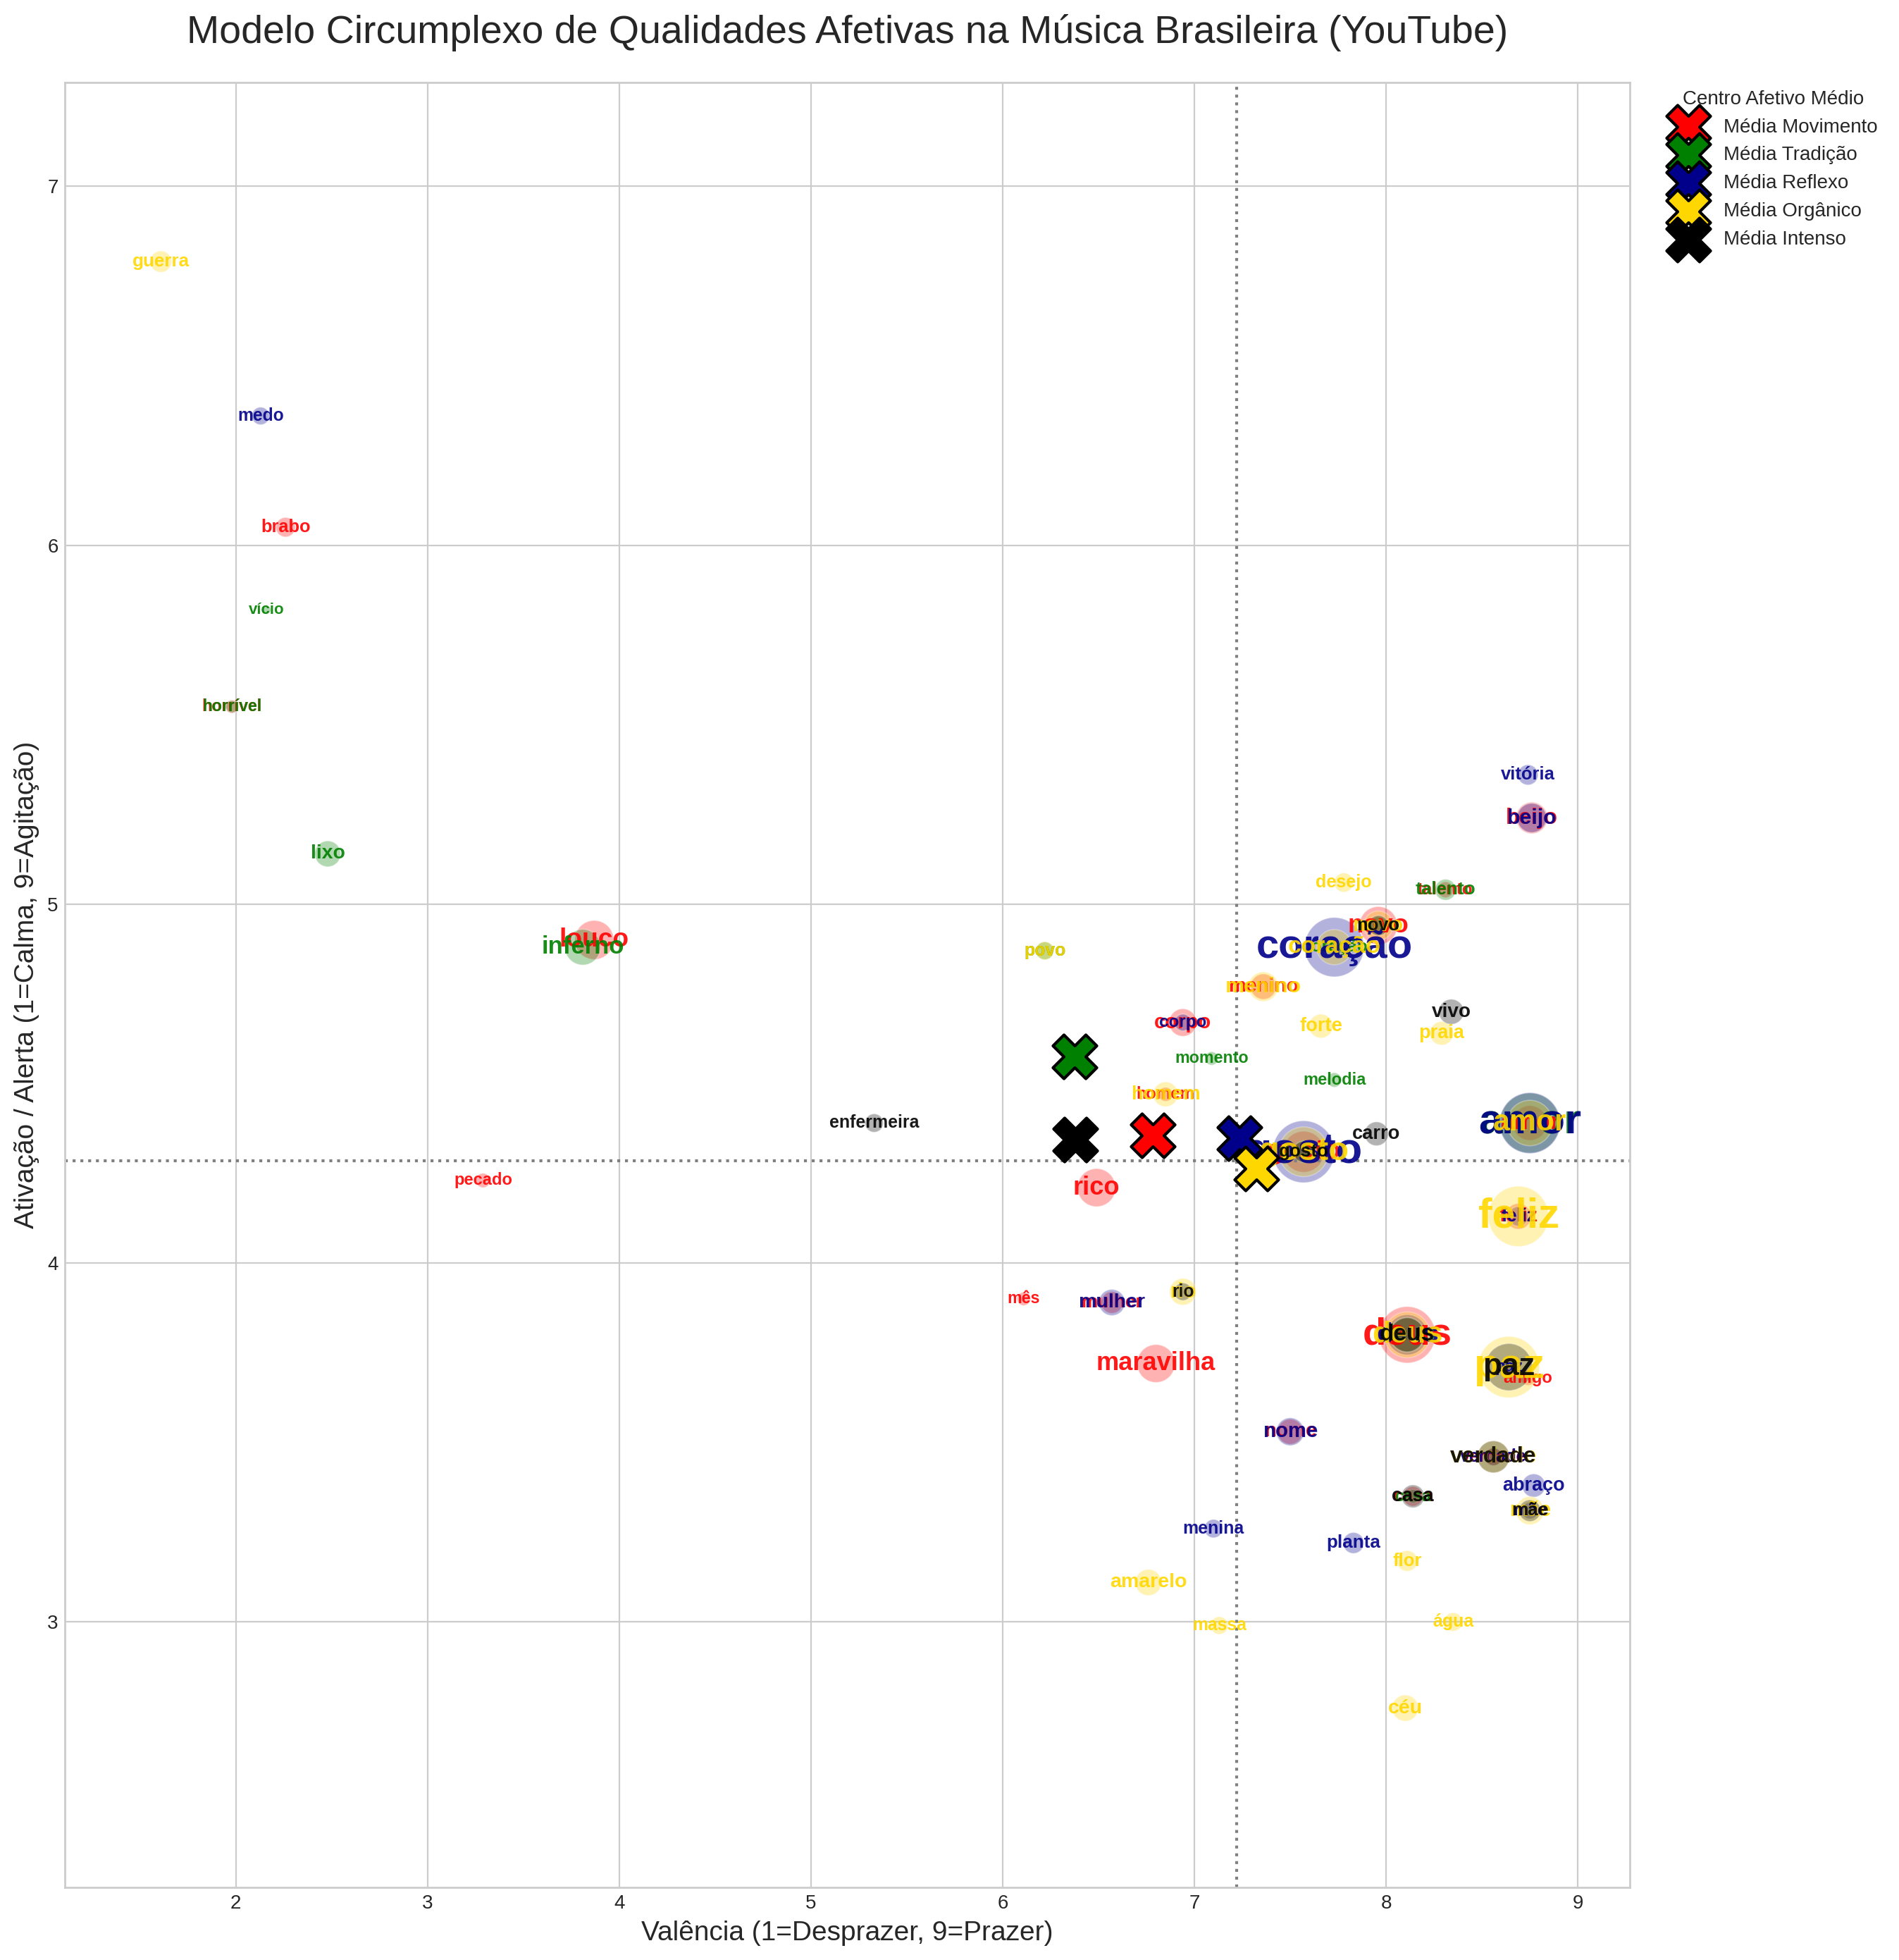

In [ ]:
# --- Gerando a visualização final ---

print("\nGerando a visualização final com tamanho de fonte dinâmico...")
if df_plot_final.empty:
    print("Nenhum dado para plotar. Verifique seu léxico e suas contagens.")
else:
    # 1. Definir a paleta de cores personalizada
    cores_personalizadas = {
        'Movimento': 'red', 'Reflexo': 'darkblue', 'Tradição': 'green',
        'Intenso': 'black', 'Orgânico': 'gold'
    }

    # 2. Configurar o gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 14))

    # 3. Plotar as bolhas de fundo (opcional, mas visualmente agradável)
    # Vamos torná-las bem sutis para que o texto seja o foco principal.
    sns.scatterplot(
        data=df_plot_final, x='valencia', y='ativacao', hue='fator',
        palette=cores_personalizadas, size='frequencia', sizes=(20, 1000),
        alpha=0.3, ax=ax, legend=False # Legenda desativada
    )

    # 4. Adicionar o nome de cada palavra com TAMANHO DINÂMICO
    # Normalizar a frequência para um intervalo de tamanho de fonte (ex: 8 a 22)
    freq_min = df_plot_final['frequencia'].min()
    freq_max = df_plot_final['frequencia'].max()
    tamanho_min_fonte = 8
    tamanho_max_fonte = 22

    for index, row in df_plot_final.iterrows():
        # Mapeamento linear da frequência para o tamanho da fonte
        tamanho_fonte = np.interp(row['frequencia'], [freq_min, freq_max], [tamanho_min_fonte, tamanho_max_fonte])

        ax.text(
            x=row['valencia'], y=row['ativacao'], s=row['palavra'],
            fontdict=dict(
                color=cores_personalizadas.get(row['fator']),
                size=tamanho_fonte, # Tamanho da fonte agora é dinâmico
                weight='bold', # Deixar em negrito para melhor leitura
                ha='center', # Centralizar o texto no ponto
                va='center'
            ),
            alpha=0.9
        )

    # 5. Plotar os "centros de gravidade" e criar a LEGENDA
    for fator_nome in df_perfil_afetivo['Fator_RITMO'].unique():
        perfil = df_perfil_afetivo[df_perfil_afetivo['Fator_RITMO'] == fator_nome]
        if not perfil.empty:
            cor_fator = cores_personalizadas.get(fator_nome, 'gray')
            ax.scatter(
                x=perfil['Valencia_Media'], y=perfil['Ativacao_Media'],
                marker='X', s=500,
                color=cor_fator,
                edgecolor='black',
                linewidth=1.5,
                zorder=10,
                # A mágica da legenda acontece aqui:
                label=f'Média {fator_nome}'
            )

    # 6. Configurações finais do gráfico
    ax.axhline(df_plot_final['ativacao'].mean(), color='gray', linestyle=':')
    ax.axvline(df_plot_final['valencia'].mean(), color='gray', linestyle=':')
    ax.set_xlabel('Valência (1=Desprazer, 9=Prazer)', fontsize=14)
    ax.set_ylabel('Ativação / Alerta (1=Calma, 9=Agitação)', fontsize=14)
    ax.set_title('Modelo Circumplexo de Qualidades Afetivas na Música Brasileira (YouTube)', fontsize=20, pad=20)

    # Definir limites para dar um pouco de "respiro"
    ax.set_xlim(df_plot_final['valencia'].min() - 0.5, df_plot_final['valencia'].max() + 0.5)
    ax.set_ylim(df_plot_final['ativacao'].min() - 0.5, df_plot_final['ativacao'].max() + 0.5)

    # 7. Exibir a legenda na lateral direita
    ax.legend(title='Centro Afetivo Médio', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta o layout para garantir que a legenda não seja cortada
    plt.show()

In [ ]:
try:
    df_plot_final
except NameError:
    print("ERRO: O DataFrame 'df_plot_final' não foi encontrado.")
    print("Por favor, rode o código que cruza os dados do léxico com a contagem de palavras primeiro.")
else:
    # 1. Selecionar as colunas de interesse
    # O DataFrame já tem tudo o que precisamos, então não precisamos criar nada novo.

    # 2. Ordenar os dados para facilitar a leitura
    # Vamos ordenar primeiro pelo fator, e depois pela frequência (da maior para a menor)
    df_tabela_final = df_plot_final.sort_values(
        by=['fator', 'frequencia'],
        ascending=[True, False]
    ).reset_index(drop=True) # Reseta o índice para ficar limpo (0, 1, 2...)

    # Renomear as colunas para a tabela final ficar mais clara
    df_tabela_final.rename(columns={
        'fator': 'Fator RITMO',
        'palavra': 'Palavra Afetiva',
        'frequencia': 'Frequência',
        'valencia': 'Valência Média (ANEW)',
        'ativacao': 'Ativação Média (ANEW)'
    }, inplace=True)

    # 3. Exibir a tabela completa
    print("--- Tabela de Palavras Afetivas Mapeadas por Fator (usadas no gráfico) ---")

    # Ajustar as opções de exibição do Pandas para mostrar todas as linhas
    pd.set_option('display.max_rows', None)

    display(df_tabela_final)

    # Resetar as opções de exibição para o padrão depois de mostrar
    pd.reset_option('display.max_rows')

    # 4. Opcional: Salvar esta tabela em um arquivo CSV ou Excel
    nome_arquivo_tabela = 'tabela_palavras_grafico.csv'
    df_tabela_final.to_csv(nome_arquivo_tabela, index=False)
    print(f"\nTabela salva como '{nome_arquivo_tabela}'")

--- Tabela de Palavras Afetivas Mapeadas por Fator (usadas no gráfico) ---


,Fator RITMO,Palavra Afetiva,Frequência,Valência Média (ANEW),Ativação Média (ANEW)
0,Intenso,paz,184,8.64,3.71
1,Intenso,deus,112,8.11,3.80
2,Intenso,verdade,101,8.56,3.46
3,Intenso,vivo,74,8.34,4.70
4,Intenso,carro,70,7.95,4.36
5,Intenso,casa,67,8.14,3.35
6,Intenso,mãe,63,8.75,3.31
7,Intenso,gosto,61,7.57,4.31
8,Intenso,novo,59,7.96,4.94
9,Intenso,enfermeira,54,5.33,4.39



Tabela salva como 'tabela_palavras_grafico.csv'


__________________

In [ ]:
# @title Classificando Valência e Ativação com Zero-Shot

!pip install transformers torch sentencepiece -q

from transformers import pipeline

# Carregar o pipeline de Zero-Shot Classification
classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 942.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Crie esta célula logo após carregar o seu 'classifier'

# Rótulos para a dimensão de VALÊNCIA (de muito ruim a muito bom)
rotulos_valencia = [
    "extremamente negativo, horrível, odioso",
    "negativo, ruim, triste",
    "neutro, indiferente",
    "positivo, bom, feliz",
    "extremamente positivo, incrível, maravilhoso"
]

# Rótulos para a dimensão de ATIVAÇÃO (de muito calmo a muito agitado)
rotulos_ativacao = [
    "extremamente calmo, relaxante, sereno",
    "calmo, tranquilo",
    "moderado, normal",
    "agitado, energético, intenso",
    "extremamente agitado, eufórico, frenético"
]

# Mapeamento dos rótulos para uma escala numérica (1 a 9) para o gráfico
# Chave: Rótulo de texto, Valor: Ponto na escala
mapa_valencia_para_numero = {
    "extremamente negativo, horrível, odioso": 0,
    "negativo, ruim, triste": 1,
    "neutro, indiferente": 2,
    "positivo, bom, feliz": 3,
    "extremamente positivo, incrível, maravilhoso": 4,
}

mapa_ativacao_para_numero = {
    "extremamente calmo, relaxante, sereno": 0,
    "calmo, tranquilo": 1,
    "moderado, normal": 2,
    "agitado, energético, intenso": 3,
    "extremamente agitado, eufórico, frenético": 4,
}

print("Rótulos e mapas de conversão definidos com sucesso.")

Rótulos e mapas de conversão definidos com sucesso.


In [ ]:
tqdm.pandas()

def classificar_afeto_zs_granular(texto):
    if not isinstance(texto, str) or len(texto.split()) < 2:
        return None, None
    try:
        # Classifica Valência
        resultado_val = classifier(texto, rotulos_valencia, multi_label=False)
        rotulo_val = resultado_val['labels'][0]
        numero_val = mapa_valencia_para_numero.get(rotulo_val) # Converte para número

        # Classifica Ativação
        resultado_ati = classifier(texto, rotulos_ativacao, multi_label=False)
        rotulo_ati = resultado_ati['labels'][0]
        numero_ati = mapa_ativacao_para_numero.get(rotulo_ati) # Converte para número

        return numero_val, numero_ati
    except Exception as e:
        # print(f"Erro ao processar texto: {texto} | Erro: {e}")
        return None, None

# --- TESTE EM UMA AMOSTRA PEQUENA PRIMEIRO ---
print("Iniciando teste de classificação em uma amostra de 100 comentários...")
df_amostra = df_robusto.sample(100, random_state=42).copy() # .copy() evita warnings

# O '.progress_apply' vai mostrar uma barra de progresso, muito útil para processos longos
df_amostra[['valencia_zs', 'ativacao_zs']] = df_amostra['text'].progress_apply(
    lambda x: pd.Series(classificar_afeto_zs_granular(x))
)

print("\nTeste concluído. Verificando os resultados da amostra:")
display(df_amostra[['text', 'valencia_zs', 'ativacao_zs']].head())

Iniciando teste de classificação em uma amostra de 100 comentários...


  0%|          | 0/100 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Teste concluído. Verificando os resultados da amostra:


,text,valencia_zs,ativacao_zs
33553,Eu vi para aqui pq os meninos cantaram essa mú...,4.0,3.0
9427,Ele parece com o Paulo Gustavo,4.0,4.0
199,Diamo🎉❤😊😮,NaN,NaN
12447,Nois vai descer pra BC kkkkkkkk,2.0,3.0
39489,"AS MELHORES BANDA DO BRASIL CIDADE NEGRA ,QUE ...",4.0,3.0


In [ ]:
# @title Filtragem para selecionar só os comentários que tem os termos alvo palavras-chave afetivas encontradas no data set (com mais algumas)

# 1. Definir a lista completa de palavras-chave
palavras_chave_afetivas = list(set([
    'amo', 'linda', 'top', 'gosto', 'charmosa', 'louco', 'dançando', 'maravilha', 'chique',
    'amor', 'ruim', 'amei', 'inferno', 'perfeita', 'viciada', 'recordações', 'gostei',
    'pedrada', 'pancada', 'lixo', 'coração', 'dispara', 'vibe', 'penso', 'lembro',
    'maravilhosa', 'graça', 'paz', 'feliz', 'chore', 'foda', 'descanse', 'merda',
    'bons', 'delicia', 'grande', 'triste', 'tristeza', 'chato', 'chata', 'saudade',
    'melancolia', 'melancólico', 'desanimado', 'desânimo', 'monótono', 'sozinho',
    'vazio', 'chorei', 'chorando', 'calma', 'calmo', 'relaxante', 'relaxar',
    'tranquilo', 'tranquilidade', 'sereno', 'serenidade', 'conforto', 'confortável',
    'suave', 'leve', 'gostoso'
]))
print(f"Usando {len(palavras_chave_afetivas)} palavras-chave afetivas únicas para a filtragem.")

# 2. Criar o padrão de busca e filtrar o DataFrame
padrao_regex = r'\b(' + '|'.join(palavras_chave_afetivas) + r')\b'
print("\nFiltrando o dataset para manter apenas comentários relevantes...")

# A MÁGICA ESTÁ AQUI: .copy() cria um DataFrame novo e independente
df_filtrado = df_robusto[df_robusto['text'].str.contains(padrao_regex, case=False, na=False)].copy()

print(f"Filtragem concluída. O novo dataset tem {len(df_filtrado)} comentários.")

Usando 63 palavras-chave afetivas únicas para a filtragem.

Filtrando o dataset para manter apenas comentários relevantes...


/tmp/ipython-input-19-2829083701.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtrado = df_robusto[df_robusto['text'].str.contains(padrao_regex, case=False, na=False)].copy()


Filtragem concluída. O novo dataset tem 11080 comentários.


In [ ]:
# @title Classificação com modelo de zero-shot classification

# Carregar o modelo
classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli", device=0) # device=0 força o uso da GPU
print("Modelo carregado.")

# Definir rótulos e mapas de conversão
rotulos_valencia = ["muito negativo", "negativo", "neutro", "positivo", "muito positivo"]
rotulos_ativacao = ["muito calmo", "calmo", "moderado", "agitado", "muito agitado"]
mapa_valencia_para_numero = {rotulo: i for i, rotulo in enumerate(rotulos_valencia)}
mapa_ativacao_para_numero = {rotulo: i for i, rotulo in enumerate(rotulos_ativacao)}

# 3. Definir a função de classificação
def classificar_afeto_zs_likert(texto):
    if not isinstance(texto, str) or len(texto.split()) < 2: return None, None
    try:
        val = classifier(texto, rotulos_valencia, multi_label=False)
        ati = classifier(texto, rotulos_ativacao, multi_label=False)
        numero_val = mapa_valencia_para_numero.get(val['labels'][0])
        numero_ati = mapa_ativacao_para_numero.get(ati['labels'][0])
        return numero_val, numero_ati
    except Exception:
        return None, None

# 4. Aplicar a classificação (este é o passo demorado)
print(f"\nIniciando a classificação dos {len(df_filtrado)} comentários.")
resultados_classificacao = df_filtrado['text'].progress_apply(
    lambda x: pd.Series(classificar_afeto_zs_likert(x))
)
df_filtrado.loc[:, ['valencia_zs', 'ativacao_zs']] = resultados_classificacao.values

print("\nClassificação concluída!")
# Salvar este resultado para não precisar rodar de novo!
df_filtrado.to_csv('comentarios_classificados_final.csv', index=False)
print("Resultados salvos em 'comentarios_classificados_final.csv'")

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Modelo carregado.

Iniciando a classificação dos 11080 comentários.


  0%|          | 0/11080 [00:00<?, ?it/s]


Classificação concluída!
Resultados salvos em 'comentarios_classificados_final.csv'


In [ ]:
import pandas as pd

# Carregar o seu dataset já classificado
caminho_csv_classificado = 'comentarios_classificados_final.csv'
df_com_nulos = pd.read_csv(caminho_csv_classificado)

print("--- Dados Antes da Limpeza Final ---")
print(f"Total de linhas: {len(df_com_nulos)}")
print("Contagem de nulos:")
print(df_com_nulos[['valencia_zs', 'ativacao_zs']].isnull().sum())

# A MÁGICA ESTÁ AQUI: .dropna() remove as linhas com valores nulos
# subset=['valencia_zs', 'ativacao_zs'] -> diz para olhar apenas para estas colunas
df_classificado_limpo = df_com_nulos.dropna(subset=['valencia_zs', 'ativacao_zs']).copy()

print("\n--- Dados Após a Limpeza Final ---")
print(f"Total de linhas restantes: {len(df_classificado_limpo)}")
print("Nova contagem de nulos:")
print(df_classificado_limpo[['valencia_zs', 'ativacao_zs']].isnull().sum())

--- Dados Antes da Limpeza Final ---
Total de linhas: 11080
Contagem de nulos:
valencia_zs    377
ativacao_zs    377
dtype: int64

--- Dados Após a Limpeza Final ---
Total de linhas restantes: 10703
Nova contagem de nulos:
valencia_zs    0
ativacao_zs    0
dtype: int64


In [ ]:
# @title Preparar os dados para gráfico
from collections import Counter
import numpy as np

# Supondo que 'palavras_chave_afetivas' já foi definido

# Usar o DataFrame limpo
df_classificado_limpo['texto_limpo'] = df_classificado_limpo['text'].str.lower()

dados_para_plotar_final = []
for palavra in palavras_chave_afetivas:
    comentarios_com_palavra = df_classificado_limpo[
        df_classificado_limpo['texto_limpo'].str.contains(f"\\b{palavra}\\b", na=False)
    ]
    if len(comentarios_com_palavra) > 3:
        val_media = comentarios_com_palavra['valencia_zs'].mean()
        ati_media = comentarios_com_palavra['ativacao_zs'].mean()
        frequencia = len(comentarios_com_palavra)
        fator_dominante = comentarios_com_palavra['fator_ritmo'].mode()[0]
        dados_para_plotar_final.append({
            'fator': fator_dominante, 'palavra': palavra, 'frequencia': frequencia,
            'valencia': val_media, 'ativacao': ati_media
        })
df_plot_final = pd.DataFrame(dados_para_plotar_final)

df_perfil_afetivo_final = df_classificado_limpo.groupby('fator_ritmo')[['valencia_zs', 'ativacao_zs']].mean().reset_index()

print("\nDados prontos para o plot.")


Dados prontos para o plot.


In [ ]:
import pandas as pd

# ==============================================================================
# PASSO 1: VERIFICAR O DATAFRAME APÓS A CLASSIFICAÇÃO E LIMPEZA
# ==============================================================================
# Supondo que 'df_classificado_limpo' foi o nome que demos ao DataFrame final
# após remover os valores nulos.

print("--- DIAGNÓSTICO DO DATAFRAME CLASSIFICADO E LIMPO ('df_classificado_limpo') ---")

try:
    # Informações gerais: tipos de dados e contagem de nulos
    print("\n[INFO] Informações gerais do DataFrame:")
    df_classificado_limpo.info()

    # Estatísticas descritivas das colunas de valência e ativação
    print("\n[STATS] Estatísticas descritivas para as colunas de classificação:")
    # Isso nos mostrará a média, desvio padrão, mínimo, máximo, etc.
    # Se os valores de 'mean', 'min', 'max' estiverem fora da nossa escala (0-4), há um problema.
    display(df_classificado_limpo[['valencia_zs', 'ativacao_zs']].describe())

    # Ver a distribuição de valores para cada categoria
    print("\n[DISTRIBUIÇÃO] Distribuição dos valores classificados para VALÊNCIA:")
    print(df_classificado_limpo['valencia_zs'].value_counts())

    print("\n[DISTRIBUIÇÃO] Distribuição dos valores classificados para ATIVAÇÃO:")
    print(df_classificado_limpo['ativacao_zs'].value_counts())

except NameError:
    print("\nERRO: O DataFrame 'df_classificado_limpo' não foi encontrado.")
    print("Certifique-se de que a etapa de remoção de nulos foi executada.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")


# ==============================================================================
# PASSO 2: VERIFICAR O DATAFRAME PRONTO PARA O PLOT
# ==============================================================================
# Supondo que 'df_plot_final' foi o nome que demos ao DataFrame que alimenta o gráfico.

print("\n\n--- DIAGNÓSTICO DO DATAFRAME PARA VISUALIZAÇÃO ('df_plot_final') ---")

try:
    print(f"\n[INFO] O DataFrame para o plot tem {len(df_plot_final)} linhas.")

    # Verificar se há valores nulos neste DataFrame final
    print("\n[NULOS] Contagem de valores nulos no DataFrame do plot:")
    print(df_plot_final.isnull().sum())

    # Exibir as primeiras e últimas linhas para ver a faixa de valores
    print("\n[AMOSTRA] Primeiras 5 linhas dos dados para o plot:")
    display(df_plot_final.head())
    print("\n[AMOSTRA] Últimas 5 linhas dos dados para o plot:")
    display(df_plot_final.tail())

except NameError:
    print("\nERRO: O DataFrame 'df_plot_final' não foi encontrado.")
    print("Certifique-se de que a etapa de preparação para o gráfico foi executada.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")

--- DIAGNÓSTICO DO DATAFRAME CLASSIFICADO E LIMPO ('df_classificado_limpo') ---

[INFO] Informações gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 10703 entries, 0 to 11079
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   author        10690 non-null  object 
 1   published_at  10703 non-null  object 
 2   text          10703 non-null  object 
 3   like_count    10703 non-null  int64  
 4   fator_ritmo   10703 non-null  object 
 5   texto_limpo   10703 non-null  object 
 6   valencia_zs   10703 non-null  float64
 7   ativacao_zs   10703 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 752.6+ KB

[STATS] Estatísticas descritivas para as colunas de classificação:


,valencia_zs,ativacao_zs
count,10703.000000,10703.000000
mean,2.780903,2.812669
std,0.943915,0.785628
min,0.000000,0.000000
25%,3.000000,3.000000
50%,3.000000,3.000000
75%,3.000000,3.000000
max,4.000000,4.000000



[DISTRIBUIÇÃO] Distribuição dos valores classificados para VALÊNCIA:
valencia_zs
3.0    7102
4.0    1609
1.0    1400
2.0     311
0.0     281
Name: count, dtype: int64

[DISTRIBUIÇÃO] Distribuição dos valores classificados para ATIVAÇÃO:
ativacao_zs
3.0    8110
1.0     988
4.0     966
2.0     461
0.0     178
Name: count, dtype: int64


--- DIAGNÓSTICO DO DATAFRAME PARA VISUALIZAÇÃO ('df_plot_final') ---

[INFO] O DataFrame para o plot tem 55 linhas.

[NULOS] Contagem de valores nulos no DataFrame do plot:
fator         0
palavra       0
frequencia    0
valencia      0
ativacao      0
dtype: int64

[AMOSTRA] Primeiras 5 linhas dos dados para o plot:


,fator,palavra,frequencia,valencia,ativacao
0,Intenso,delicia,107,3.149533,2.897196
1,Intenso,saudade,211,2.530806,2.834123
2,Tradição,pancada,87,1.632184,3.080460
3,Orgânico,paz,508,2.834646,1.435039
4,Movimento,dançando,105,2.542857,2.771429



[AMOSTRA] Últimas 5 linhas dos dados para o plot:


,fator,palavra,frequencia,valencia,ativacao
50,Reflexo,calmo,5,2.200000,1.400000
51,Tradição,viciada,154,2.889610,3.155844
52,Reflexo,vazio,6,1.666667,2.333333
53,Tradição,pedrada,125,1.744000,2.960000
54,Tradição,lixo,167,1.077844,3.017964



Gerando o gráfico final com jitter para melhor visualização...


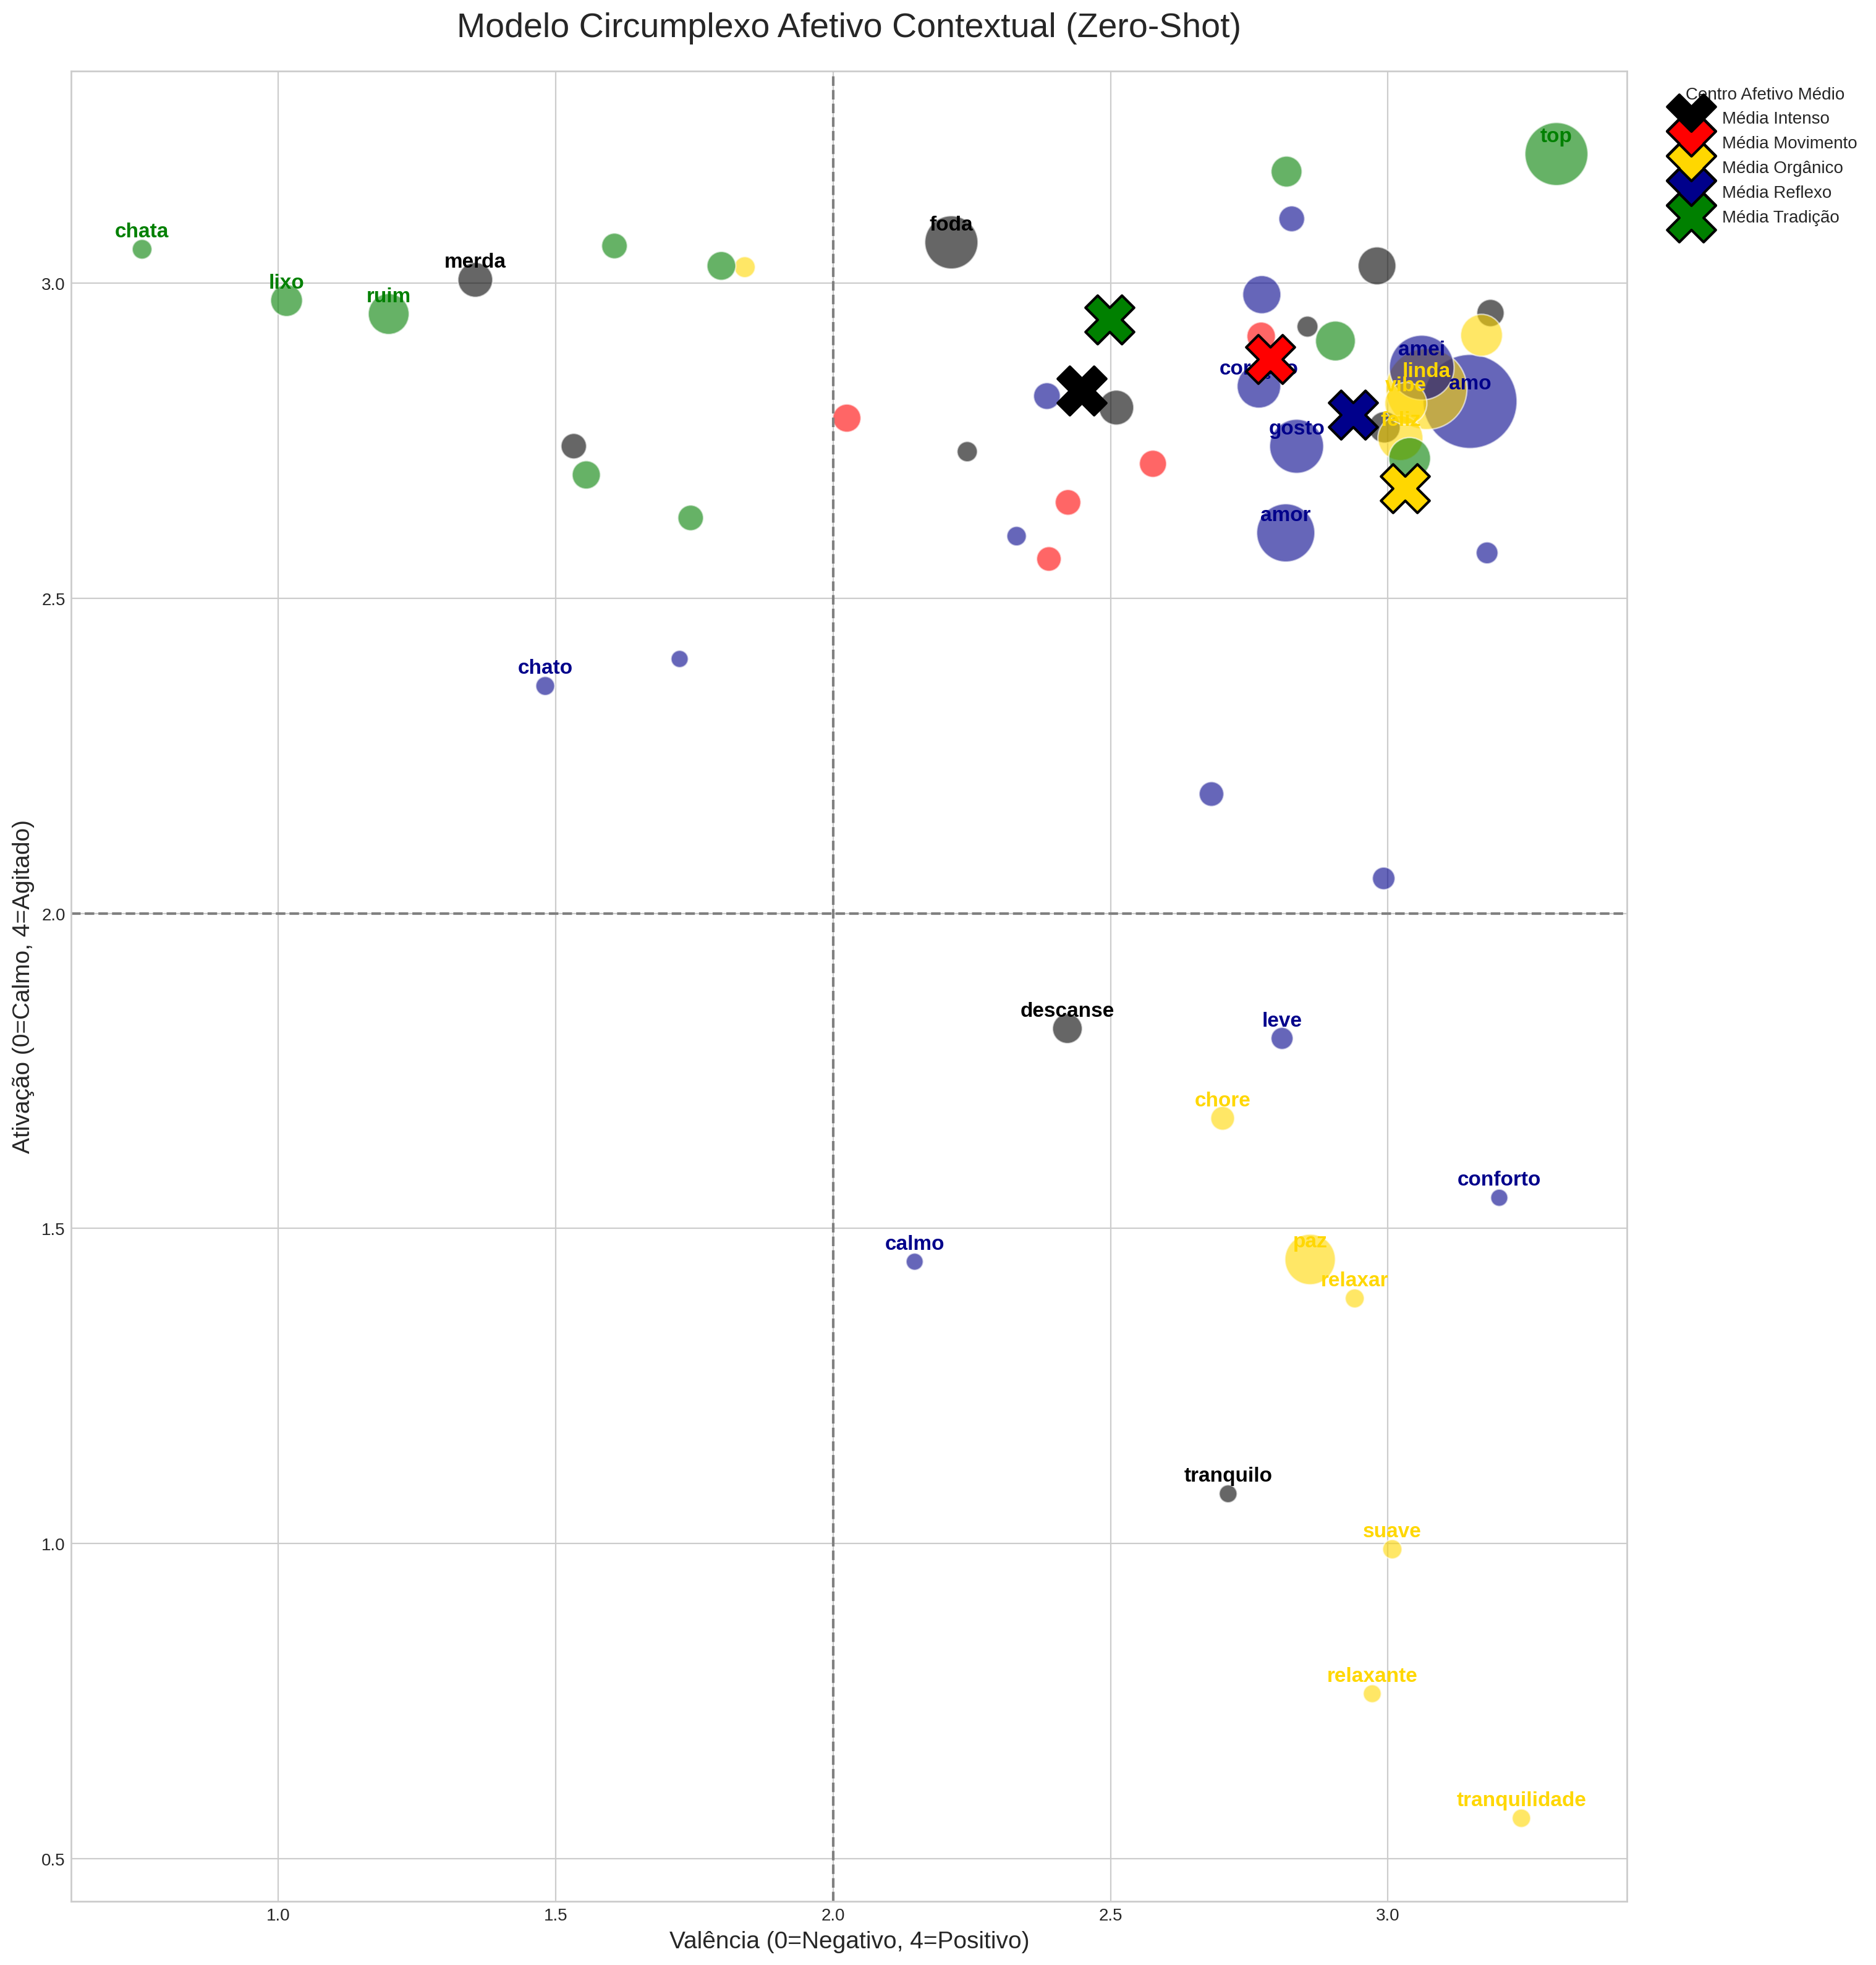

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supondo que 'df_plot_final' e 'df_perfil_afetivo_final' já foram criados.

# --- PASSO 1: ADICIONAR "JITTER" AO DATAFRAME DE PLOTAGEM ---
# Adicionar um pequeno valor aleatório para espalhar os pontos
jitter_strength = 0.08
df_plot_final['valencia_jitter'] = df_plot_final['valencia'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot_final))
df_plot_final['ativacao_jitter'] = df_plot_final['ativacao'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot_final))


# --- PASSO 2: VISUALIZAÇÃO COM JITTER E ANOTAÇÃO INTELIGENTE ---
print("\nGerando o gráfico final com jitter para melhor visualização...")

cores_personalizadas = {
    'Movimento': 'red', 'Reflexo': 'darkblue', 'Tradição': 'green',
    'Intenso': 'black', 'Orgânico': 'gold'
}
fig, ax = plt.subplots(figsize=(18, 16))
plt.style.use('seaborn-v0_8-whitegrid')

# PLOTAR OS PONTOS COM JITTER
sns.scatterplot(
    data=df_plot_final,
    x='valencia_jitter', # Usar a coluna com jitter
    y='ativacao_jitter', # Usar a coluna com jitter
    hue='fator',
    palette=cores_personalizadas,
    size='frequencia',
    sizes=(100, 3000),
    alpha=0.6,
    ax=ax,
    legend=False
)

# ANOTAR DE FORMA INTELIGENTE (apenas as palavras mais importantes/extremas)
for index, row in df_plot_final.iterrows():
    # Condição para anotar: ser uma das mais frequentes OU estar nos extremos do gráfico
    if row['frequencia'] > df_plot_final['frequencia'].quantile(0.80) or \
       row['valencia'] < 1.5 or row['valencia'] > 3.5 or \
       row['ativacao'] < 2.0 or row['ativacao'] > 3.5:

        ax.text(
            x=row['valencia_jitter'], y=row['ativacao_jitter']+0.02, s=row['palavra'],
            fontdict=dict(
                color=cores_personalizadas.get(row['fator'], 'gray'),
                size=12, weight='bold', ha='center'
            )
        )

# Plotar os centros de gravidade
for index, row in df_perfil_afetivo_final.iterrows():
    fator_nome = row['fator_ritmo']
    ax.scatter(
        x=row['valencia_zs'], y=row['ativacao_zs'], marker='X', s=800,
        color=cores_personalizadas.get(fator_nome, 'gray'),
        edgecolor='black', linewidth=1.5, zorder=10,
        label=f'Média {fator_nome}'
    )

# Configurações finais
ax.axvline(x=2, color='gray', linestyle='--')
ax.axhline(y=2, color='gray', linestyle='--')
ax.set_xlabel('Valência (0=Negativo, 4=Positivo)', fontsize=14)
ax.set_ylabel('Ativação (0=Calmo, 4=Agitado)', fontsize=14)
ax.set_title('Modelo Circumplexo Afetivo Contextual (Zero-Shot)', fontsize=20, pad=20)
ax.legend(title='Centro Afetivo Médio', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [ ]:
# @title Top10 pavras classificadas
try:
    top_10_por_fator = df_plot_final.groupby('fator').apply(
        lambda x: x.nlargest(10, 'frequencia')
    ).reset_index(drop=True)

    # Renomear as colunas para a tabela final ficar mais clara e profissional
    top_10_por_fator.rename(columns={
        'fator': 'Fator RITMO',
        'palavra': 'Palavra-Chave Afetiva',
        'frequencia': 'Frequência de Ocorrência',
        'valencia': 'Valência Média (ZS)',
        'ativacao': 'Ativação Média (ZS)'
    }, inplace=True)

    # Arredondar os valores de valência e ativação para 2 casas decimais
    top_10_por_fator['Valência Média (ZS)'] = top_10_por_fator['Valência Média (ZS)'].round(2)
    top_10_por_fator['Ativação Média (ZS)'] = top_10_por_fator['Ativação Média (ZS)'].round(2)


    # Exibir a tabela final
    print("\nTabela com as 10 palavras mais frequentes por fator e suas coordenadas afetivas:")

    # Configurar Pandas para exibir a tabela completa
    pd.set_option('display.max_rows', 100)

    display(top_10_por_fator)

    pd.reset_option('display.max_rows')

    # Opcional: Salvar esta tabela crucial em um arquivo CSV
    top_10_por_fator.to_csv('tabela_top10_palavras_por_fator.csv', index=False)
    # print("\nTabela salva em 'tabela_top10_palavras_por_fator.csv'")

except NameError:
    print("\nERRO: O DataFrame 'df_plot_zs' não foi encontrado.")
    print("Por favor, execute a etapa de preparação para o gráfico primeiro.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")


Tabela com as 10 palavras mais frequentes por fator e suas coordenadas afetivas:


/tmp/ipython-input-17-3598458246.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_por_fator = df_plot_final.groupby('fator').apply(


,Fator RITMO,Palavra-Chave Afetiva,Frequência de Ocorrência,Valência Média (ZS),Ativação Média (ZS),valencia_jitter,ativacao_jitter
0,Intenso,foda,570,2.25,3.11,2.213193,3.064725
1,Intenso,grande,260,2.93,2.97,2.980410,3.027445
2,Intenso,saudade,211,2.53,2.83,2.510491,2.802551
3,Intenso,merda,210,1.28,2.96,1.355041,3.005247
4,Intenso,bons,161,2.98,2.70,2.993846,2.771279
5,Intenso,descanse,137,2.39,1.82,2.422304,1.816975
6,Intenso,delicia,107,3.15,2.90,3.184960,2.952578
7,Intenso,triste,85,1.52,2.76,1.532515,2.741305
8,Intenso,sozinho,39,2.85,2.90,2.855056,2.930998
9,Intenso,tristeza,32,2.19,2.75,2.241775,2.732616


___


Tentativa de pegar comentários com baixa ativação (de preferência baixa valência também)

In [ ]:
# @title Baixa ativação

videos_baixa_ativacao = {
    'musica_dormir': '-RH-lM2BMcQ',    # Vídeo: "Bons Sonhos 💤 Música Relaxante..."
    'musica_triste1': '4YWd1d4HoFE',    # Vídeo: "Home - Tom Rosenthal [ Tradução/ legendado ]"
    'musica_triste2': 'xvJ6FxnJsRA'     # Vídeo: Tom Rosenthal - Home // [tradução-legendado]
}

print("--- Coletando comentários de contextos de Baixa Ativação ---")
lista_dfs_baixa_ativacao = []

# Agora este loop vai funcionar perfeitamente
for contexto, video_id in videos_baixa_ativacao.items():
    print(f"\nColetando para o contexto: '{contexto}' (Vídeo ID: {video_id})")

    # Chama a função de coleta para este vídeo
    df_contexto = coletar_comentarios(video_id, limit=5000)

    # Adiciona os comentários coletados à lista do fator
    if not df_contexto.empty:
        df_contexto['contexto'] = contexto # Identifica a origem do comentário
        lista_dfs_baixa_ativacao.append(df_contexto)
        print(f"  -> Coletados {len(df_contexto)} comentários.")
    else:
        print(f"  -> Nenhum comentário coletado ou ocorreu um erro para o vídeo {video_id}.")

# Verificar se coletamos algum comentário
if lista_dfs_baixa_ativacao:
    # Juntar todos os DataFrames de comentários em um só
    df_baixa_ativacao = pd.concat(lista_dfs_baixa_ativacao, ignore_index=True)
    print(f"\nColeta concluída. Total de {len(df_baixa_ativacao)} comentários.")
else:
    print("\nColeta concluída. Nenhum comentário foi coletado.")
    # Criar um DataFrame vazio para evitar erros nos próximos passos
    df_baixa_ativacao = pd.DataFrame(columns=['text', 'contexto'])

--- Coletando comentários de contextos de Baixa Ativação ---

Coletando para o contexto: 'musica_dormir' (Vídeo ID: -RH-lM2BMcQ)
  -> Coletados 5000 comentários.

Coletando para o contexto: 'musica_triste1' (Vídeo ID: 4YWd1d4HoFE)
  -> Coletados 965 comentários.

Coletando para o contexto: 'musica_triste2' (Vídeo ID: xvJ6FxnJsRA)
  -> Coletados 985 comentários.

Coleta concluída. Total de 6950 comentários.


In [ ]:
def limpar_texto(texto):
    if not isinstance(texto, str):
        return ""
    # Remove URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    # Remove menções e hashtags
    texto = re.sub(r'\@\w+|\#\w+', '', texto)
    # Converte para minúsculas
    texto = texto.lower()
    # Remove pontuação
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    # Remove números (opcional, mas recomendado)
    texto = re.sub(r'\d+', '', texto)
    # Remove espaços em branco extras
    texto = " ".join(texto.split())
    return texto


# --- PASSO 2: PREPARAR A LISTA COMPLETA DE STOPWORDS ---
# Vamos usar a mesma lista abrangente que criamos para o estudo principal.
print("Preparando a lista de stopwords...")
try:
    portuguese_stops = set(stopwords.words('portuguese'))
except LookupError:
    nltk.download('stopwords')
    portuguese_stops = set(stopwords.words('portuguese'))

# Palavras genéricas para ignorar
palavras_extras_gerais = {
    'música', 'som', 'letra', 'clipe', 'video', 'gente', 'tá', 'né', 'faz', 'ver', 'sempre',
    'ainda', 'tudo', 'coisa', 'dia', 'dms', 'aqui', 'pra', 'vou', 'vai', 'ser', 'ter',
    'quer', 'mim', 'bem', 'agora', 'tão', 'só', 'vc', 'mt', 'td', 'essa', 'esse',
    'obrigado', 'obrigada', 'deus', 'noite', 'boa', 'todos', 'q', 'vida', 'bom',
    'musica', 'paz', 'amo', 'nunca', 'jesus', 'sei', 'sono', 'ouvindo', 'alguém',
    'consigo', 'anos', 'coração', 'sinto', 'melhor', 'amor', 'ouvir', 'pessoas',
    'vídeo', 'comentários'
}

# Palavras contextuais dos vídeos (tanto do estudo principal quanto deste)
stopwords_contexto = {
    # Estudo principal
    'joão', 'gomes', 'tuto', 'glenner', 'barbie', 'nilo', 'paiva', 'marques', 'fuimlk', 'mlk',
    'brenno', 'matheus', 'descer', 'bc', 'simone', 'mendes', 'saudade', 'proibida', 'jão',
    'anavitoria', 'anavitória', 'vitor', 'kley', 'pupila', 'lagum', 'iza', 'cidade', 'negra',
    'girassol', 'natiruts', 'torture', 'squad', 'fallen', 'ones', 'matanza', 'mal', 'raimundos',
    'oco', 'shaman', 'carry', 'idiota', 'devo', 'explicações', 'deve', 'deixou', 'tubarões', 'mar',
    'saber', 'guina','❤',
    # Estudo complementar (adicionar palavras dos novos vídeos se necessário)
    'dormir', 'relaxar', 'estudar', 'tranquilo', 'calma', 'home', 'rosenthal'
}

# Juntar todas as stopwords
portuguese_stops.update(palavras_extras_gerais)
portuguese_stops.update(stopwords_contexto)
print("Lista de stopwords pronta.")


# --- PASSO 3: APLICAR A LIMPEZA NO DATAFRAME 'df_baixa_ativacao' ---
print("\nIniciando a limpeza dos novos comentários...")

# Garantir que não há textos nulos
df_baixa_ativacao.dropna(subset=['text'], inplace=True)

# 1. Aplicar a limpeza básica para criar 'texto_limpo'
df_baixa_ativacao['texto_limpo'] = df_baixa_ativacao['text'].apply(limpar_texto)

# 2. Criar a coluna 'texto_processado' sem as stopwords
def remover_stopwords(texto):
    palavras_filtradas = [palavra for palavra in texto.split() if palavra not in portuguese_stops]
    return " ".join(palavras_filtradas)

df_baixa_ativacao['texto_processado'] = df_baixa_ativacao['texto_limpo'].apply(remover_stopwords)

print("Limpeza concluída.")

# --- PASSO 4: VERIFICAR O RESULTADO ---
print("\nAmostra dos dados após a limpeza:")
display(df_baixa_ativacao[['text', 'texto_limpo', 'texto_processado']].head())

# Salvar o DataFrame limpo para uso futuro
#df_baixa_ativacao.to_csv('comentarios_baixa_ativacao_limpos.csv', index=False)
#print("\nDataFrame limpo salvo como 'comentarios_baixa_ativacao_limpos.csv'")

Preparando a lista de stopwords...
Lista de stopwords pronta.

Iniciando a limpeza dos novos comentários...
Limpeza concluída.

Amostra dos dados após a limpeza:


,text,texto_limpo,texto_processado
0,Me lembra meu sonho de Deus 😂😂😂😂😂😂😂❤❤❤❤❤❤❤😊,me lembra meu sonho de deus 😂😂😂😂😂😂😂❤❤❤❤❤❤❤😊,lembra sonho 😂😂😂😂😂😂😂❤❤❤❤❤❤❤😊
1,Alguém em 1990?,alguém em,
2,🙏 Gratidão 🤗❤️,🙏 gratidão 🤗❤️,🙏 gratidão 🤗❤️
3,Assim seja obrigado Espírito Santo,assim seja obrigado espírito santo,assim espírito santo
4,Eu amo pq essa música é a unica fora a deus na...,eu amo pq essa música é a unica fora a deus na...,pq unica acalmar crises nao dormi oro abençoe ...


In [ ]:
from collections import Counter

# ==============================================================================
# PRÉ-REQUISITO:
# O DataFrame 'df_baixa_ativacao' já deve existir e conter a coluna 'texto_processado',
# que é a versão do texto limpa e sem stopwords.
# ==============================================================================

print("--- Verificando as 30 palavras mais frequentes no corpus de Baixa Ativação ---")

try:
    # 1. Juntar todo o texto processado em uma única "textão"
    # Usamos .dropna() para garantir que não haja valores nulos que possam causar erro.
    textao_baixa_ativacao = " ".join(df_baixa_ativacao['texto_processado'].dropna())

    # 2. Separar o textão em uma lista de palavras
    # Não precisamos mais remover stopwords aqui, pois já fizemos isso.
    lista_de_palavras_ba = textao_baixa_ativacao.split()

    # 3. Contar a frequência das palavras
    contagem_palavras_ba = Counter(lista_de_palavras_ba)

    # 4. Exibir as 30 palavras mais comuns
    numero_de_palavras_para_mostrar = 200
    palavras_mais_comuns = contagem_palavras_ba.most_common(numero_de_palavras_para_mostrar)

    print(f"\nAs {numero_de_palavras_para_mostrar} palavras mais comuns são:")
    # Imprimir em um formato mais legível
    for palavra, contagem in palavras_mais_comuns:
        print(f"- {palavra}: {contagem} vezes")

except NameError:
    print("\nERRO: O DataFrame 'df_baixa_ativacao' não foi encontrado.")
    print("Por favor, execute a etapa de coleta e limpeza primeiro.")
except KeyError:
    print("\nERRO: A coluna 'texto_processado' não foi encontrada no DataFrame.")
    print("Certifique-se de que o código de limpeza foi executado com sucesso.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")

--- Verificando as 30 palavras mais frequentes no corpus de Baixa Ativação ---

As 200 palavras mais comuns são:
- abençoe: 280 vezes
- casa: 242 vezes
- ❤: 238 vezes
- dormi: 204 vezes
- dias: 169 vezes
- fazer: 167 vezes
- quero: 165 vezes
- ansiedade: 165 vezes
- pessoa: 164 vezes
- nada: 161 vezes
- n: 158 vezes
- cada: 152 vezes
- todo: 152 vezes
- assim: 150 vezes
- tô: 150 vezes
- lembra: 149 vezes
- coisas: 149 vezes
- tempo: 146 vezes
- hoje: 145 vezes
- pq: 144 vezes
- ama: 144 vezes
- amei: 141 vezes
- músicas: 141 vezes
- medo: 141 vezes
- lugar: 138 vezes
- linda: 128 vezes
- relaxante: 127 vezes
- toda: 127 vezes
- feliz: 126 vezes
- porque: 126 vezes
- nome: 125 vezes
- pois: 125 vezes
- queria: 122 vezes
- mãe: 122 vezes
- vezes: 121 vezes
- tanto: 121 vezes
- mundo: 120 vezes
- amém: 120 vezes
- durmo: 119 vezes
- gratidão: 117 vezes
- momento: 117 vezes
- you: 117 vezes
- senhor: 115 vezes
- nao: 114 vezes
- todas: 113 vezes
- i: 112 vezes
- escuto: 112 vezes
- vez: 1

In [ ]:
# Carregar o dataset do estudo principal (use a versão balanceada, se tiver)
df_principal = pd.read_csv('comentarios_youtube_balanceado.csv')
# Se não tiver o balanceado, use o 'comentarios_youtube_robusto.csv'

# Carregar o dataset do estudo complementar (o que acabamos de coletar)
df_complementar = pd.read_csv('comentarios_baixa_ativacao_limpos.csv')
# Renomear a coluna 'contexto' para 'fator_ritmo' para consistência
df_complementar.rename(columns={'contexto': 'fator_ritmo'}, inplace=True)


# Combinar os dois DataFrames em um único dataset final
df_combinado = pd.concat([df_principal, df_complementar], ignore_index=True)

print("--- Datasets Combinados ---")
print(f"Total de comentários para análise: {len(df_combinado)}")
print("\nDistribuição final por fator/contexto:")
print(df_combinado['fator_ritmo'].value_counts())


# --- PASSO 2 (CORRIGIDO): Filtrar o Dataset Combinado com a Lista Completa ---

# Lista de palavras-chave originais, selecionadas dos fatores RITMO
palavras_chave_originais = [
    'amo', 'linda', 'top', 'gosto', 'charmosa', 'louco', 'dançando', 'maravilha', 'chique',
    'amor', 'ruim', 'amei', 'inferno', 'perfeita', 'viciada', 'recordações', 'gostei',
    'pedrada', 'pancada', 'lixo', 'coração', 'dispara', 'vibe', 'penso', 'lembro',
    'maravilhosa', 'graça', 'feliz', 'chore', 'foda', 'descanse', 'merda',
    'bons', 'delicia', 'grande'
]

# Novas palavras que identificamos para os quadrantes de baixa ativação
palavras_baixa_ativacao = [
    # Positivas e Calmas
    'paz', 'relaxante', 'gratidão', 'acalma', 'acalmar', 'tranquilo', 'sonhos',
    'dormi', 'durmo', 'dormindo', 'dorme', 'dormiu', 'sono', 'melodia',
    'abençoe', 'conforto', 'lindo', 'suave', 'leve', 'gostoso', 'sereno',
    'serenidade', 'tranquilidade',
    # Negativas e Calmas/Complexas
    'triste', 'tristeza', 'ansiedade', 'medo', 'chorar', 'chorando', 'difícil',
    'dor', 'insônia', 'problemas', 'lembrar', 'pensamentos', 'saudade',
    'melancolia', 'melancólico', 'desanimado', 'desânimo', 'monótono',
    'sozinho', 'vazio', 'chorei'
]

# Combinar todas as listas em uma única lista final e remover duplicatas
palavras_chave_finais = list(set(palavras_chave_originais + palavras_baixa_ativacao))

print(f"Lista final e enriquecida contém {len(palavras_chave_finais)} palavras-chave únicas para a filtragem.")
print("Exemplo de algumas palavras:", sorted(palavras_chave_finais)[:30]) # Mostra as 30 primeiras em ordem alfabética


if 'texto_limpo' not in df_combinado.columns:
    df_combinado.dropna(subset=['text'], inplace=True)
    # Use a sua função de limpeza aqui. Exemplo:
    # df_combinado['texto_limpo'] = df_combinado['text'].apply(limpar_texto_avancado)
    df_combinado['texto_limpo'] = df_combinado['text'].str.lower()


# Criar o padrão de busca Regex com a lista final e enriquecida
padrao_regex = r'\b(' + '|'.join(palavras_chave_finais) + r')\b'

print(f"\nFiltrando o dataset com a lista de palavras ENRIQUECIDA...")
# .str.contains() verifica se o padrão regex existe em cada comentário
df_filtrado_final = df_combinado[df_combinado['texto_limpo'].str.contains(padrao_regex, case=False, na=False)].copy()

print(f"Dataset final filtrado contém {len(df_filtrado_final)} comentários relevantes.")

--- Datasets Combinados ---
Total de comentários para análise: 56950

Distribuição final por fator/contexto:
fator_ritmo
Movimento         10000
Tradição          10000
Reflexo           10000
Orgânico          10000
Intenso           10000
musica_dormir      5000
musica_triste2      985
musica_triste1      965
Name: count, dtype: int64
Lista final e enriquecida contém 79 palavras-chave únicas para a filtragem.
Exemplo de algumas palavras: ['abençoe', 'acalma', 'acalmar', 'amei', 'amo', 'amor', 'ansiedade', 'bons', 'charmosa', 'chique', 'chorando', 'chorar', 'chore', 'chorei', 'conforto', 'coração', 'dançando', 'delicia', 'desanimado', 'descanse', 'desânimo', 'difícil', 'dispara', 'dor', 'dorme', 'dormi', 'dormindo', 'dormiu', 'durmo', 'feliz']

Filtrando o dataset com a lista de palavras ENRIQUECIDA...


/tmp/ipython-input-36-2274211369.py:64: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtrado_final = df_combinado[df_combinado['texto_limpo'].str.contains(padrao_regex, case=False, na=False)].copy()


Dataset final filtrado contém 14732 comentários relevantes.


In [ ]:
print(f"\nIniciando a classificação final dos {len(df_filtrado_final)} comentários...")

resultados_classificacao = df_filtrado_final['text'].progress_apply(
    lambda x: pd.Series(classificar_afeto_zs_likert(x))
)
df_filtrado_final.loc[:, ['valencia_zs', 'ativacao_zs']] = resultados_classificacao.values

# Salvar o resultado mais importante da sua pesquisa!
df_filtrado_final.to_csv('dataset_final_classificado.csv', index=False)
print("\nClassificação final concluída e salva!")


Iniciando a classificação final dos 14732 comentários...


  0%|          | 0/14732 [00:00<?, ?it/s]


Classificação final concluída e salva!


In [ ]:
# @title Carregar o dataset final e classificado
caminho_csv_final = 'dataset_final_classificado.csv'
try:
    df_final = pd.read_csv(caminho_csv_final)
    # Remover qualquer linha que possa ter falhado na classificação
    df_final.dropna(subset=['valencia_zs', 'ativacao_zs'], inplace=True)
    print(f"Dataset final classificado carregado com sucesso. Contém {len(df_final)} comentários válidos.")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{caminho_csv_final}' não encontrado. A etapa de classificação precisa ser concluída primeiro.")

Dataset final classificado carregado com sucesso. Contém 14282 comentários válidos.


In [ ]:
# @title Preparar dados

# Criar a coluna de texto limpo para a busca
if 'texto_limpo' not in df_final.columns:
    df_final['texto_limpo'] = df_final['text'].str.lower() # Adapte com sua função de limpeza se necessário

print("\nCalculando as coordenadas médias para cada palavra-chave...")
dados_para_plotar = []
limite_minimo_frequencia = 5 # Manter um limite mínimo para robustez estatística

for palavra in palavras_chave_finais:
    comentarios_com_palavra = df_final[df_final['texto_limpo'].str.contains(f"\\b{palavra}\\b", na=False)]

    if len(comentarios_com_palavra) > limite_minimo_frequencia:
        val_media_zs = comentarios_com_palavra['valencia_zs'].mean()
        ati_media_zs = comentarios_com_palavra['ativacao_zs'].mean()
        frequencia = len(comentarios_com_palavra)
        fator_dominante = comentarios_com_palavra['fator_ritmo'].mode()[0]

        dados_para_plotar.append({
            'fator': fator_dominante, 'palavra': palavra, 'frequencia': frequencia,
            'valencia': val_media_zs, 'ativacao': ati_media_zs
        })

df_plot_final = pd.DataFrame(dados_para_plotar)

# Calcular os centros de gravidade dos fatores
df_perfil_afetivo_final = df_final.groupby('fator_ritmo')[['valencia_zs', 'ativacao_zs']].mean().reset_index()

print("Dados prontos para o plot.")


Calculando as coordenadas médias para cada palavra-chave...
Dados prontos para o plot.


In [ ]:
# @title Tabela com o Top 10

print("\n--- Tabela com as 10 Palavras Mais Frequentes por Fator e Suas Coordenadas Afetivas ---")

top_10_por_fator = df_plot_final.groupby('fator').apply(
    lambda x: x.nlargest(10, 'frequencia')
).reset_index(drop=True)

# Arredondar e renomear para a apresentação
top_10_por_fator['valencia'] = top_10_por_fator['valencia'].round(2)
top_10_por_fator['ativacao'] = top_10_por_fator['ativacao'].round(2)
top_10_por_fator.rename(columns={
    'fator': 'Fator/Contexto', 'palavra': 'Palavra-Chave', 'frequencia': 'Frequência',
    'valencia': 'Valência Média (0-4)', 'ativacao': 'Ativação Média (0-4)'
}, inplace=True)

pd.set_option('display.max_rows', 100)
display(top_10_por_fator)
pd.reset_option('display.max_rows')


--- Tabela com as 10 Palavras Mais Frequentes por Fator e Suas Coordenadas Afetivas ---


/tmp/ipython-input-40-1941242610.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_por_fator = df_plot_final.groupby('fator').apply(


,Fator/Contexto,Palavra-Chave,Frequência,Valência Média (0-4),Ativação Média (0-4)
0,Intenso,foda,544,2.27,3.12
1,Intenso,grande,311,2.91,2.82
2,Intenso,saudade,237,2.50,2.80
3,Intenso,bons,232,3.01,2.56
4,Intenso,merda,214,1.26,2.95
5,Intenso,descanse,152,2.41,1.91
6,Intenso,delicia,109,3.15,2.90
7,Movimento,maravilha,133,2.77,2.88
8,Movimento,louco,116,2.08,2.82
9,Movimento,dançando,105,2.57,2.75



Gerando o gráfico final com a paleta de cores completa...


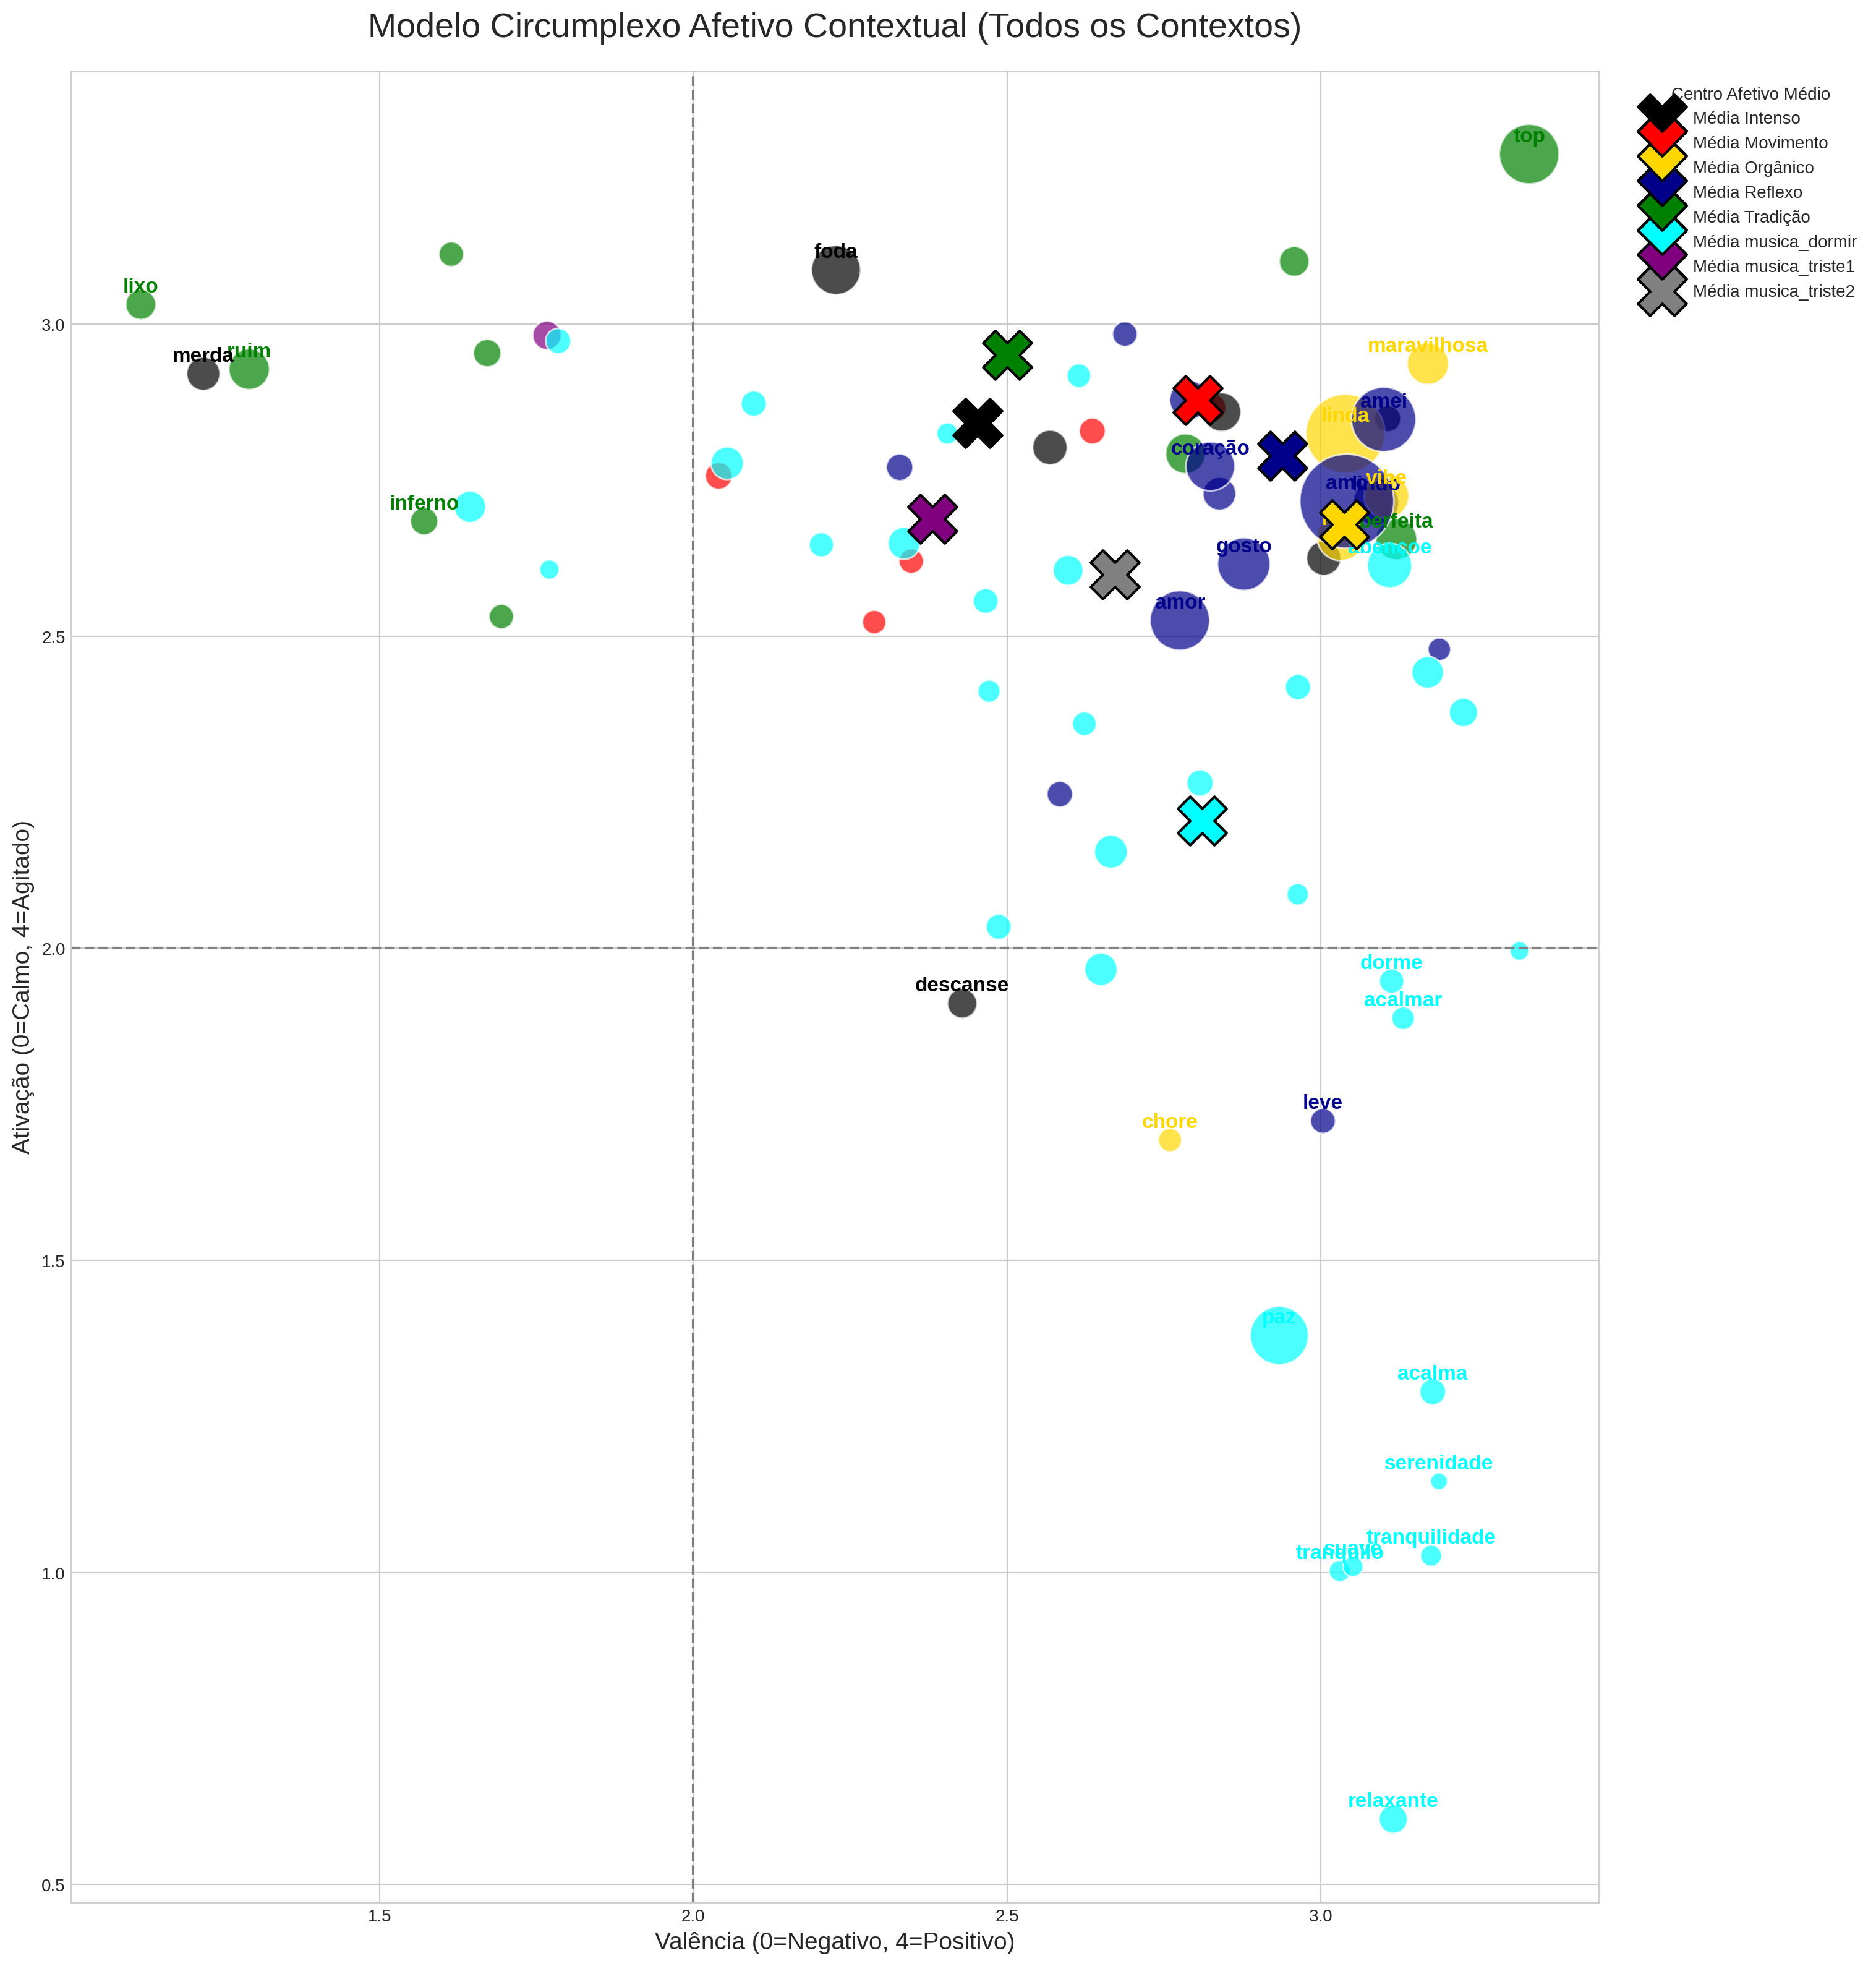

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supondo que 'df_plot_final' e 'df_perfil_afetivo_final' já foram criados.

# --- PASSO 1: ATUALIZAR O DICIONÁRIO DE CORES ---
# Adicionar entradas para os novos contextos de baixa ativação.
# Vamos escolher cores que se encaixem, por exemplo, tons de roxo e ciano.

cores_personalizadas = {
    # Fatores RITMO
    'Movimento': 'red',
    'Reflexo': 'darkblue',
    'Tradição': 'green',
    'Intenso': 'black',
    'Orgânico': 'gold',

    # Novos Contextos de Baixa Ativação
    'musica_triste1': 'purple',
    'musica_dormir': 'cyan',
    'lofi_relax': 'cyan'
}


# --- PASSO 2: VISUALIZAÇÃO COM JITTER (O código a partir daqui é o mesmo) ---
print("\nGerando o gráfico final com a paleta de cores completa...")

# Adicionar "jitter"
jitter_strength = 0.08
df_plot_final['valencia_jitter'] = df_plot_final['valencia'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot_final))
df_plot_final['ativacao_jitter'] = df_plot_final['ativacao'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot_final))

# Configurar o gráfico
fig, ax = plt.subplots(figsize=(18, 16))
plt.style.use('seaborn-v0_8-whitegrid')

# PLOTAR OS PONTOS COM JITTER E A NOVA PALETA
sns.scatterplot(
    data=df_plot_final,
    x='valencia_jitter',
    y='ativacao_jitter',
    hue='fator',
    palette=cores_personalizadas, # Agora ele encontrará todas as chaves
    size='frequencia',
    sizes=(100, 3000),
    alpha=0.7,
    ax=ax,
    legend=False
)

# ANOTAR DE FORMA INTELIGENTE
for index, row in df_plot_final.iterrows():
    if row['frequencia'] > df_plot_final['frequencia'].quantile(0.80) or \
       row['valencia'] < 1.5 or row['valencia'] > 3.5 or \
       row['ativacao'] < 2.0 or row['ativacao'] > 3.5:
        ax.text(
            x=row['valencia_jitter'], y=row['ativacao_jitter']+0.02, s=row['palavra'],
            fontdict=dict(
                color=cores_personalizadas.get(row['fator'], 'gray'),
                size=12, weight='bold', ha='center'
            )
        )

# Plotar os centros de gravidade
for index, row in df_perfil_afetivo_final.iterrows():
    fator_nome = row['fator_ritmo']
    ax.scatter(
        x=row['valencia_zs'], y=row['ativacao_zs'], marker='X', s=800,
        color=cores_personalizadas.get(fator_nome, 'gray'),
        edgecolor='black', linewidth=1.5, zorder=10,
        label=f'Média {fator_nome}'
    )

# Configurações finais e legenda
ax.axvline(x=2, color='gray', linestyle='--')
ax.axhline(y=2, color='gray', linestyle='--')
ax.set_xlabel('Valência (0=Negativo, 4=Positivo)', fontsize=14)
ax.set_ylabel('Ativação (0=Calmo, 4=Agitado)', fontsize=14)
ax.set_title('Modelo Circumplexo Afetivo Contextual (Todos os Contextos)', fontsize=20, pad=20)
ax.legend(title='Centro Afetivo Médio', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


Gerando o gráfico simplificado (sem fatores)...


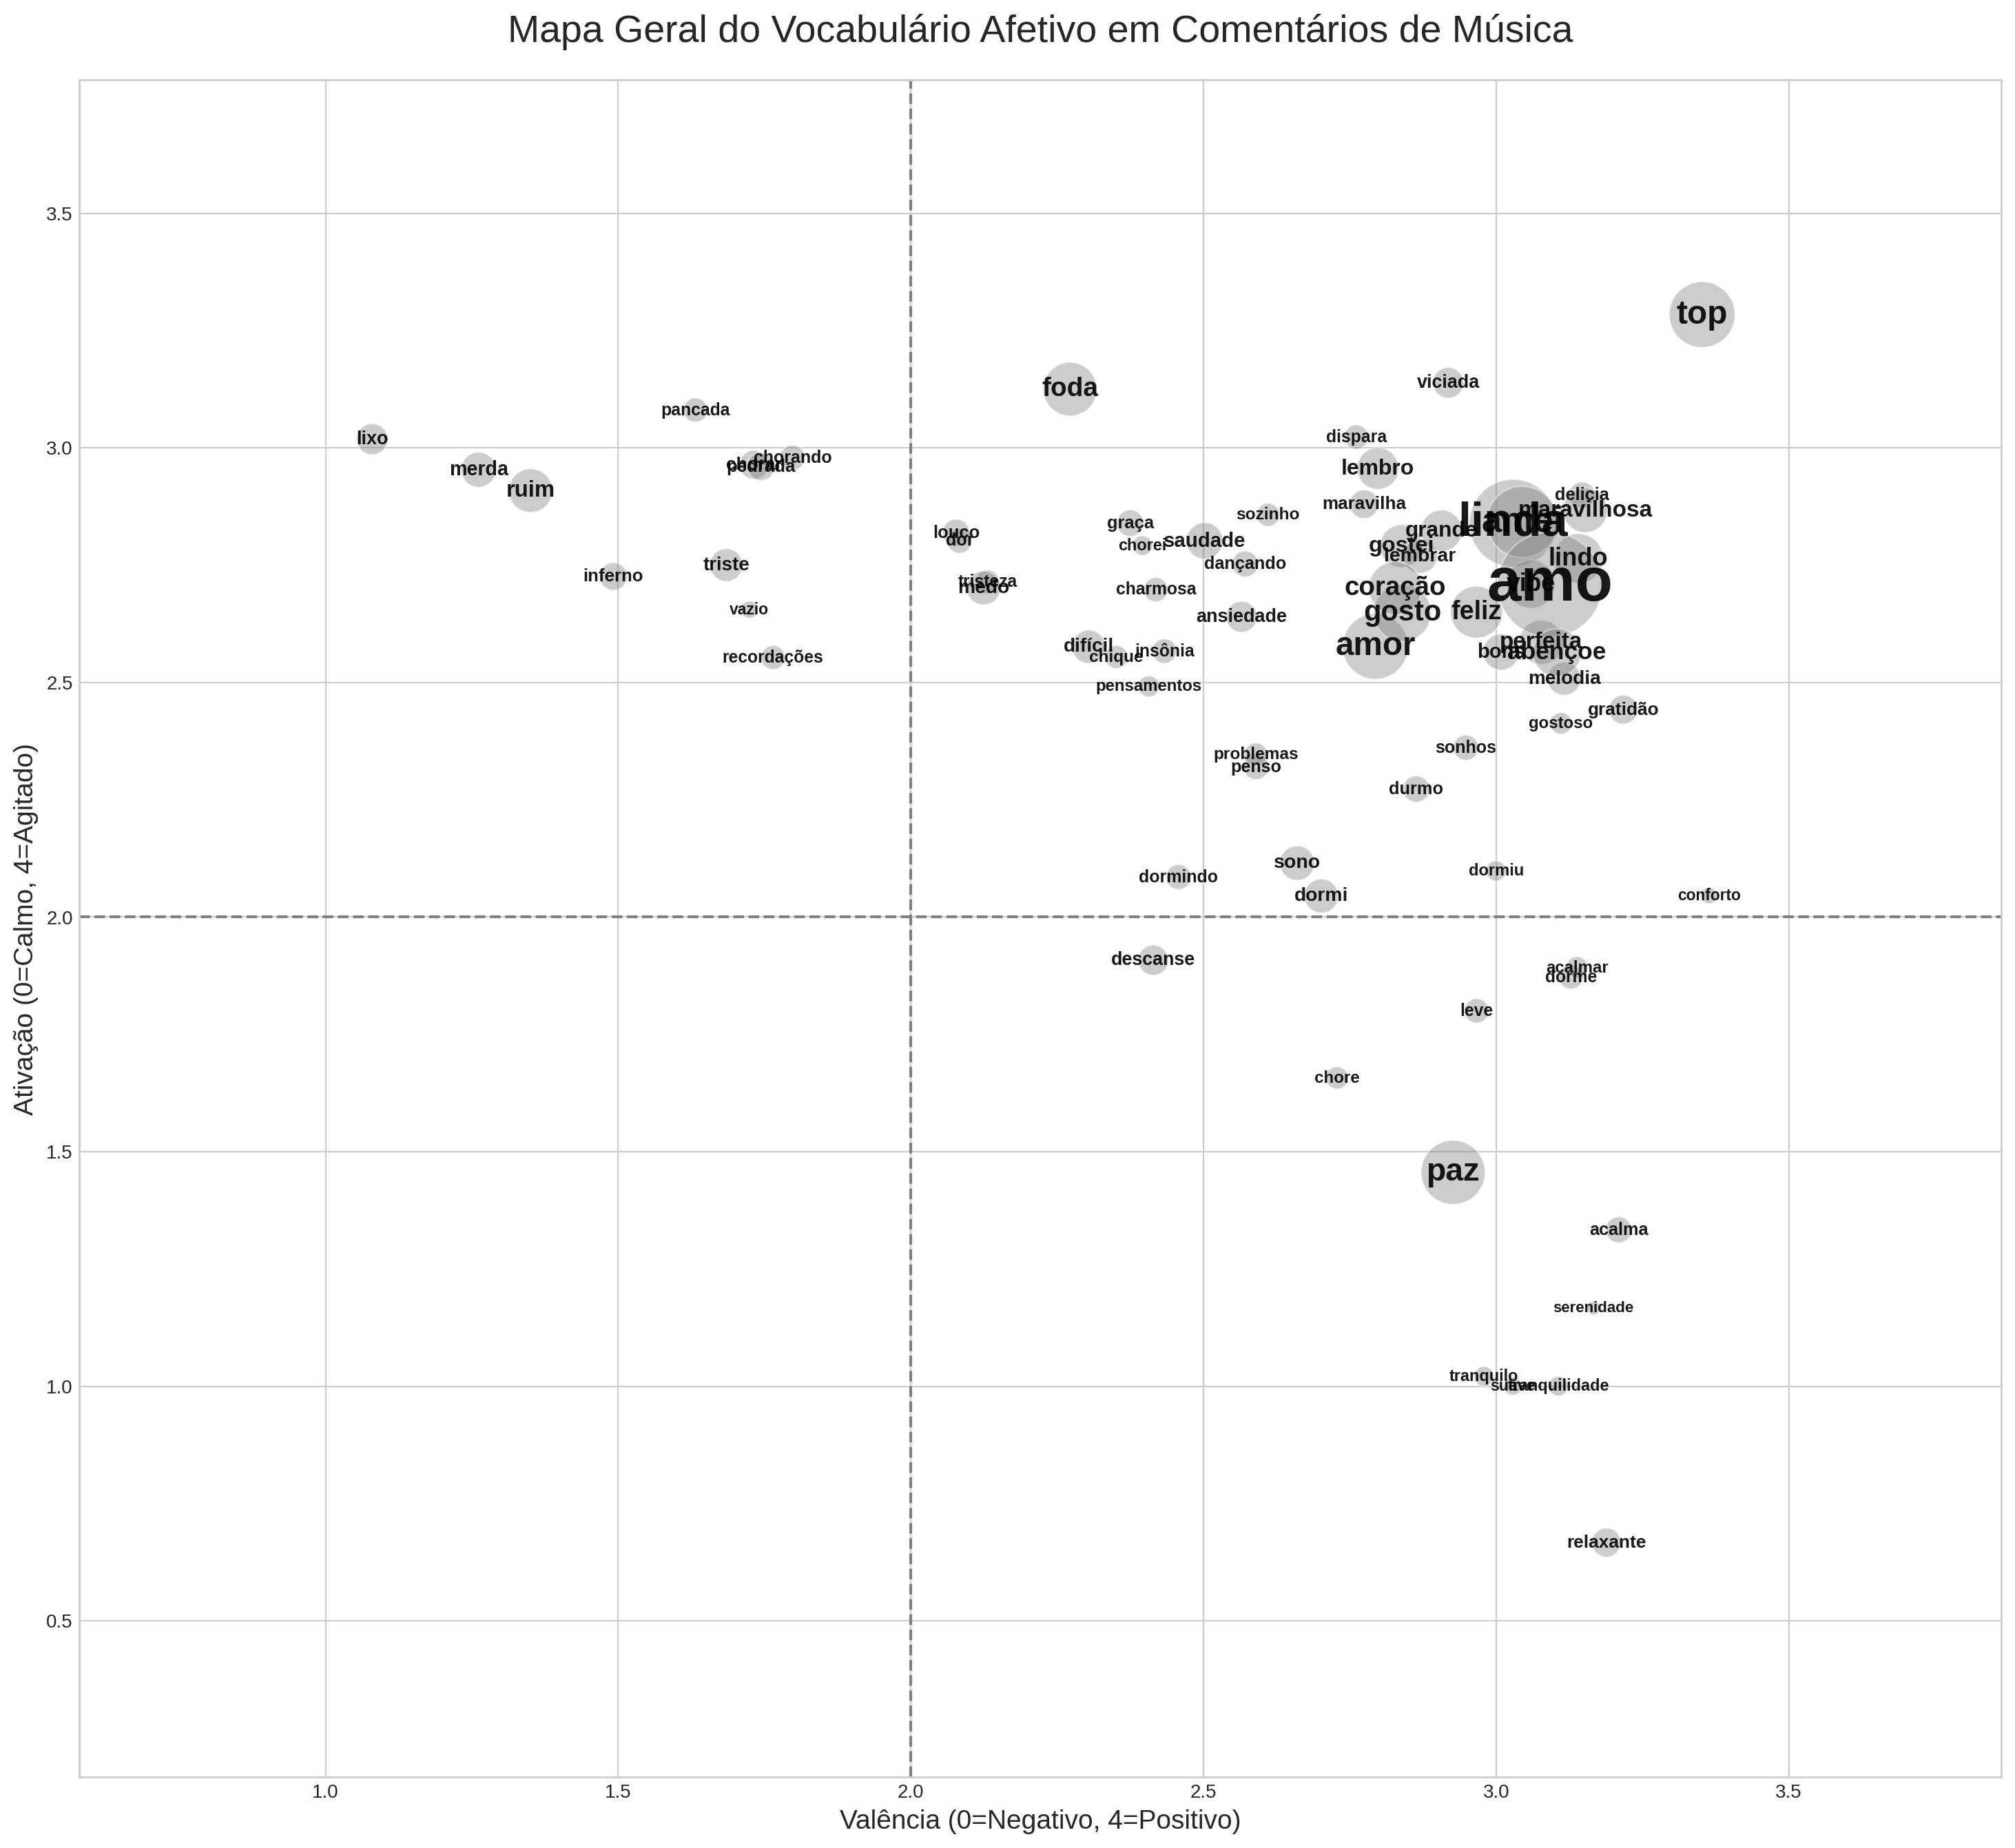

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==============================================================================
# PRÉ-REQUISITO:
# O DataFrame 'df_plot_final' (ou 'df_plot_zs', dependendo de como você o nomeou)
# já deve ter sido criado, contendo as colunas: 'palavra', 'frequencia', 'valencia', 'ativacao'.
# ==============================================================================

print("\nGerando o gráfico simplificado (sem fatores)...")

# --- PASSO 1: Definir os dados a serem plotados ---
# Não precisamos modificar o DataFrame, apenas a forma como o plotamos.
df_para_plot_geral = df_plot_final.copy() # Usando o DataFrame que já temos

# --- PASSO 2: VISUALIZAÇÃO GERAL E LIMPA ---
fig, ax = plt.subplots(figsize=(18, 16))
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Plotar os pontos de fundo (as bolhas) em uma única cor
sns.scatterplot(
    data=df_para_plot_geral,
    x='valencia', # Usar as colunas originais, sem jitter
    y='ativacao',
    size='frequencia',
    sizes=(50, 3000),
    color='gray', # Cor única para todos os pontos
    alpha=0.4,
    ax=ax,
    legend=False # Sem legenda
)

# 2. Adicionar o texto das palavras com tamanho dinâmico e cor única
freq_min, freq_max = df_para_plot_geral['frequencia'].min(), df_para_plot_geral['frequencia'].max()
tamanho_min_fonte, tamanho_max_fonte = 8, 32

for index, row in df_para_plot_geral.iterrows():
    tamanho_fonte = np.interp(row['frequencia'], [freq_min, freq_max], [tamanho_min_fonte, tamanho_max_fonte])
    ax.text(
        x=row['valencia'], y=row['ativacao'], s=row['palavra'],
        fontdict=dict(
            color='black', # Cor única para todo o texto
            size=tamanho_fonte,
            weight='bold',
            ha='center',
            va='center'
        ),
        alpha=0.9
    )

# 3. Configurações finais do gráfico (sem legenda de fatores)
ax.axvline(x=2, color='gray', linestyle='--')
ax.axhline(y=2, color='gray', linestyle='--')
ax.set_xlabel('Valência (0=Negativo, 4=Positivo)', fontsize=14)
ax.set_ylabel('Ativação (0=Calmo, 4=Agitado)', fontsize=14)
ax.set_title('Mapa Geral do Vocabulário Afetivo em Comentários de Música', fontsize=20, pad=20)

# Definir limites para um bom enquadramento
ax.set_xlim(df_para_plot_geral['valencia'].min() - 0.5, df_para_plot_geral['valencia'].max() + 0.5)
ax.set_ylim(df_para_plot_geral['ativacao'].min() - 0.5, df_para_plot_geral['ativacao'].max() + 0.5)

plt.show()

In [ ]:
import pandas as pd

# ==============================================================================
# PRÉ-REQUISITO:
# O DataFrame 'df_plot_final' já deve ter sido criado, contendo as coordenadas
# médias de valência e ativação para cada palavra-chave.
# ==============================================================================

print("--- Verificando o Quadrante Inferior Esquerdo (Baixa Valência e Baixa Ativação) ---")

# Definir os limites do quadrante
# Usamos o ponto central (2,2) como referência da nossa escala 0-4
limite_valencia = 2.0
limite_ativacao = 2.0

try:
    # Filtrar o DataFrame para encontrar palavras que atendem a AMBAS as condições
    quadrante_inferior_esquerdo = df_plot_final[
        (df_plot_final['valencia'] < limite_valencia) &
        (df_plot_final['ativacao'] < limite_ativacao)
    ]

    # Verificar o resultado da filtragem
    if quadrante_inferior_esquerdo.empty:
        # Se o DataFrame resultante estiver vazio, não encontramos nenhuma palavra.
        print("\nRESULTADO: Nenhuma palavra foi encontrada no quadrante inferior esquerdo.")
        print(f"(Condições: Valência < {limite_valencia} E Ativação < {limite_ativacao})")
        print("\nIsso confirma a observação visual de que este quadrante afetivo é pouco utilizado nos comentários de música analisados.")
    else:
        # Se encontrarmos alguma palavra, vamos exibi-la.
        print(f"\nRESULTADO: Foram encontradas {len(quadrante_inferior_esquerdo)} palavra(s) no quadrante inferior esquerdo:")

        # Renomear colunas para clareza
        quadrante_inferior_esquerdo_formatado = quadrante_inferior_esquerdo.rename(columns={
            'fator': 'Fator Dominante',
            'palavra': 'Palavra-Chave',
            'frequencia': 'Frequência',
            'valencia': 'Valência Média (0-4)',
            'ativacao': 'Ativação Média (0-4)'
        }).round(2) # Arredondar valores

        display(quadrante_inferior_esquerdo_formatado.sort_values(by='Frequência', ascending=False))

except NameError:
    print("\nERRO: O DataFrame 'df_plot_final' não foi encontrado.")
    print("Por favor, execute a etapa de preparação para o gráfico primeiro.")
except KeyError:
    print("\nERRO: Certifique-se de que as colunas 'valencia' e 'ativacao' existem no DataFrame.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")

--- Verificando o Quadrante Inferior Esquerdo (Baixa Valência e Baixa Ativação) ---

RESULTADO: Nenhuma palavra foi encontrada no quadrante inferior esquerdo.
(Condições: Valência < 2.0 E Ativação < 2.0)

Isso confirma a observação visual de que este quadrante afetivo é pouco utilizado nos comentários de música analisados.
